In [1]:
import os
import numpy as np
import math

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

########### Вывод изображений и сохранение ################################
import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid

In [2]:
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [3]:
n_epochs = 10000
batch_size = 64
lr = 0.0002

b1 = 0.5
b2 = 0.999

latent_dim = 10

n_classes = 10
img_size = 28
channels = 1

sample_interval = 25

img_shape = (channels, 100, 2)


In [4]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        def block(in_feat, out_feat, normalize=True,):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            
            return layers
        
        self.model = nn.Sequential(
            *block(latent_dim, 32, normalize=False),
            *block(32, 64),
            *block(64, 128),
            *block(128, 256),
            nn.Linear(256, int(np.prod(img_shape))),
            nn.Tanh()
        )
        

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.1),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.1),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )
  

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

In [6]:
def gen_batch(n):
    batch = []
    for i in range(n):
        x = np.sort(np.random.uniform(-10,10,100))
        y = np.sin(x)/x - x/10
        batch.append(np.array(list(zip(x, y))))
    return torch.Tensor(batch)

In [24]:
batch = gen_batch(1)
img = batch[0]

<IPython.core.display.Javascript object>


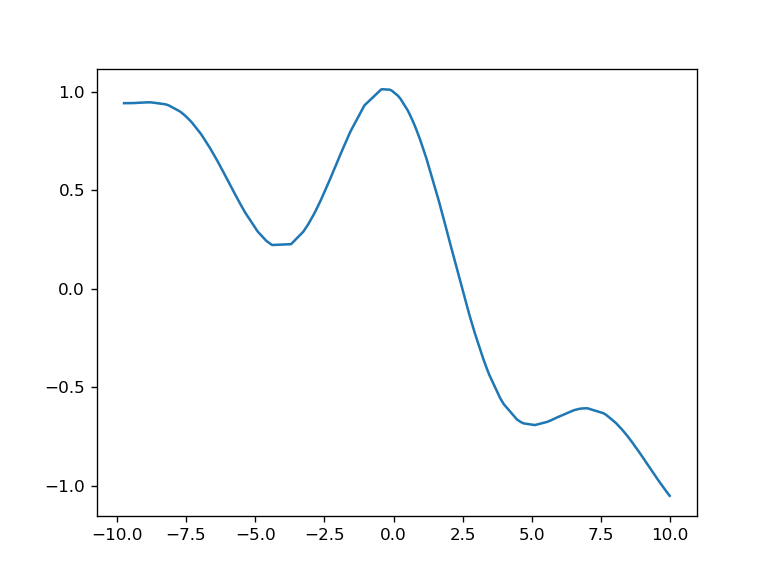

In [25]:
%matplotlib notebook
plt.plot(img[:,0],img[:,1])
plt.show()

In [7]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)


optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

adversarial_loss = torch.nn.BCELoss()

In [8]:
d_loss_history = []
g_loss_history = []

In [9]:
######## функция для вывода и сохранения изображения ########
def sample_image(static_sample, save_img = False):
    npimg = make_grid(static_sample.data[:25]).cpu().numpy()
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation="nearest")
    if save_img:
        save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

In [10]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')



for epoch in range(n_epochs):
    batch = gen_batch(batch_size)

##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
    valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)
    fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)

    real_imgs = Variable(batch.type(torch.FloatTensor)).to(device)


######################  Тренировка генератора    ##########################

    optimizer_G.zero_grad()

    #генерация шума
    z = Variable(torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device)

    gen_imgs = generator(z)

    validity = discriminator(gen_imgs)
    g_loss = adversarial_loss(validity, valid)

    g_loss.backward()
    optimizer_G.step()

######################  Тренировка дискриминатора    ##########################

    optimizer_D.zero_grad()

    real_pred = discriminator(real_imgs)
    d_real_loss = adversarial_loss(real_pred, valid)

    fake_pred = discriminator(gen_imgs.detach())
    d_fake_loss = adversarial_loss(fake_pred, fake)

    d_loss = (d_real_loss + d_fake_loss) / 2

    d_loss.backward()
    optimizer_D.step()

######## Отображение процесса обучения и вывод функций потерь ############

    print("[Epoch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, d_loss.item(), g_loss.item()) ) 


[Epoch 0/10000] [D loss: 0.576152] [G loss: 0.688886]
[Epoch 1/10000] [D loss: 0.510427] [G loss: 0.688849]
[Epoch 2/10000] [D loss: 0.464525] [G loss: 0.688579]
[Epoch 3/10000] [D loss: 0.427357] [G loss: 0.688895]
[Epoch 4/10000] [D loss: 0.411944] [G loss: 0.688051]
[Epoch 5/10000] [D loss: 0.395034] [G loss: 0.689519]
[Epoch 6/10000] [D loss: 0.382523] [G loss: 0.689519]
[Epoch 7/10000] [D loss: 0.376422] [G loss: 0.691091]
[Epoch 8/10000] [D loss: 0.369992] [G loss: 0.692301]
[Epoch 9/10000] [D loss: 0.364973] [G loss: 0.691694]
[Epoch 10/10000] [D loss: 0.361387] [G loss: 0.693063]
[Epoch 11/10000] [D loss: 0.360215] [G loss: 0.694022]
[Epoch 12/10000] [D loss: 0.356920] [G loss: 0.694458]
[Epoch 13/10000] [D loss: 0.356151] [G loss: 0.695972]
[Epoch 14/10000] [D loss: 0.354736] [G loss: 0.696577]
[Epoch 15/10000] [D loss: 0.353406] [G loss: 0.696532]
[Epoch 16/10000] [D loss: 0.352373] [G loss: 0.698751]
[Epoch 17/10000] [D loss: 0.351196] [G loss: 0.698335]
[Epoch 18/10000] [D 

[Epoch 155/10000] [D loss: 0.143353] [G loss: 1.429847]
[Epoch 156/10000] [D loss: 0.138666] [G loss: 1.459406]
[Epoch 157/10000] [D loss: 0.139568] [G loss: 1.442768]
[Epoch 158/10000] [D loss: 0.140238] [G loss: 1.424297]
[Epoch 159/10000] [D loss: 0.136659] [G loss: 1.460993]
[Epoch 160/10000] [D loss: 0.131683] [G loss: 1.510504]
[Epoch 161/10000] [D loss: 0.129633] [G loss: 1.514064]
[Epoch 162/10000] [D loss: 0.128885] [G loss: 1.515996]
[Epoch 163/10000] [D loss: 0.126951] [G loss: 1.514353]
[Epoch 164/10000] [D loss: 0.125063] [G loss: 1.541041]
[Epoch 165/10000] [D loss: 0.127300] [G loss: 1.555331]
[Epoch 166/10000] [D loss: 0.123893] [G loss: 1.532157]
[Epoch 167/10000] [D loss: 0.121512] [G loss: 1.534240]
[Epoch 168/10000] [D loss: 0.124846] [G loss: 1.560819]
[Epoch 169/10000] [D loss: 0.122002] [G loss: 1.590016]
[Epoch 170/10000] [D loss: 0.123696] [G loss: 1.569431]
[Epoch 171/10000] [D loss: 0.118582] [G loss: 1.575353]
[Epoch 172/10000] [D loss: 0.119782] [G loss: 1.

[Epoch 306/10000] [D loss: 0.020980] [G loss: 3.287723]
[Epoch 307/10000] [D loss: 0.020184] [G loss: 3.310161]
[Epoch 308/10000] [D loss: 0.023089] [G loss: 3.257916]
[Epoch 309/10000] [D loss: 0.022419] [G loss: 3.211605]
[Epoch 310/10000] [D loss: 0.022558] [G loss: 3.117280]
[Epoch 311/10000] [D loss: 0.022347] [G loss: 3.269708]
[Epoch 312/10000] [D loss: 0.024594] [G loss: 3.315061]
[Epoch 313/10000] [D loss: 0.024305] [G loss: 3.156533]
[Epoch 314/10000] [D loss: 0.024654] [G loss: 3.117684]
[Epoch 315/10000] [D loss: 0.019974] [G loss: 3.236543]
[Epoch 316/10000] [D loss: 0.019903] [G loss: 3.383509]
[Epoch 317/10000] [D loss: 0.019635] [G loss: 3.406514]
[Epoch 318/10000] [D loss: 0.021910] [G loss: 3.221130]
[Epoch 319/10000] [D loss: 0.022833] [G loss: 3.175491]
[Epoch 320/10000] [D loss: 0.022478] [G loss: 3.257343]
[Epoch 321/10000] [D loss: 0.022445] [G loss: 3.359057]
[Epoch 322/10000] [D loss: 0.022391] [G loss: 3.137455]
[Epoch 323/10000] [D loss: 0.024050] [G loss: 3.

[Epoch 457/10000] [D loss: 0.010484] [G loss: 3.927667]
[Epoch 458/10000] [D loss: 0.009092] [G loss: 4.099867]
[Epoch 459/10000] [D loss: 0.007925] [G loss: 4.278004]
[Epoch 460/10000] [D loss: 0.006444] [G loss: 4.415795]
[Epoch 461/10000] [D loss: 0.006551] [G loss: 4.648271]
[Epoch 462/10000] [D loss: 0.006143] [G loss: 4.621803]
[Epoch 463/10000] [D loss: 0.007562] [G loss: 4.548560]
[Epoch 464/10000] [D loss: 0.007714] [G loss: 4.219564]
[Epoch 465/10000] [D loss: 0.008156] [G loss: 4.202084]
[Epoch 466/10000] [D loss: 0.008103] [G loss: 4.290167]
[Epoch 467/10000] [D loss: 0.006641] [G loss: 4.391064]
[Epoch 468/10000] [D loss: 0.006927] [G loss: 4.362890]
[Epoch 469/10000] [D loss: 0.012040] [G loss: 4.388050]
[Epoch 470/10000] [D loss: 0.013070] [G loss: 3.873503]
[Epoch 471/10000] [D loss: 0.013075] [G loss: 3.820504]
[Epoch 472/10000] [D loss: 0.010070] [G loss: 4.081192]
[Epoch 473/10000] [D loss: 0.006998] [G loss: 4.368053]
[Epoch 474/10000] [D loss: 0.006135] [G loss: 4.

[Epoch 609/10000] [D loss: 0.002925] [G loss: 5.312684]
[Epoch 610/10000] [D loss: 0.002545] [G loss: 5.408470]
[Epoch 611/10000] [D loss: 0.002863] [G loss: 5.437303]
[Epoch 612/10000] [D loss: 0.002715] [G loss: 5.461848]
[Epoch 613/10000] [D loss: 0.002522] [G loss: 5.397066]
[Epoch 614/10000] [D loss: 0.002440] [G loss: 5.401317]
[Epoch 615/10000] [D loss: 0.004536] [G loss: 5.448665]
[Epoch 616/10000] [D loss: 0.003482] [G loss: 4.937738]
[Epoch 617/10000] [D loss: 0.004292] [G loss: 4.863907]
[Epoch 618/10000] [D loss: 0.003909] [G loss: 4.877823]
[Epoch 619/10000] [D loss: 0.003529] [G loss: 5.077024]
[Epoch 620/10000] [D loss: 0.002860] [G loss: 5.225429]
[Epoch 621/10000] [D loss: 0.002817] [G loss: 5.365537]
[Epoch 622/10000] [D loss: 0.002470] [G loss: 5.421484]
[Epoch 623/10000] [D loss: 0.002267] [G loss: 5.609462]
[Epoch 624/10000] [D loss: 0.002193] [G loss: 5.695815]
[Epoch 625/10000] [D loss: 0.002098] [G loss: 5.537737]
[Epoch 626/10000] [D loss: 0.002019] [G loss: 5.

[Epoch 765/10000] [D loss: 0.001827] [G loss: 5.857850]
[Epoch 766/10000] [D loss: 0.001740] [G loss: 5.805123]
[Epoch 767/10000] [D loss: 0.001672] [G loss: 5.832965]
[Epoch 768/10000] [D loss: 0.001844] [G loss: 5.874445]
[Epoch 769/10000] [D loss: 0.001947] [G loss: 5.857713]
[Epoch 770/10000] [D loss: 0.001839] [G loss: 5.906507]
[Epoch 771/10000] [D loss: 0.002184] [G loss: 5.867585]
[Epoch 772/10000] [D loss: 0.001871] [G loss: 5.693789]
[Epoch 773/10000] [D loss: 0.002014] [G loss: 5.732950]
[Epoch 774/10000] [D loss: 0.001803] [G loss: 5.634583]
[Epoch 775/10000] [D loss: 0.001661] [G loss: 5.755589]
[Epoch 776/10000] [D loss: 0.001834] [G loss: 5.884016]
[Epoch 777/10000] [D loss: 0.002879] [G loss: 5.808773]
[Epoch 778/10000] [D loss: 0.002161] [G loss: 5.758397]
[Epoch 779/10000] [D loss: 0.002160] [G loss: 5.567544]
[Epoch 780/10000] [D loss: 0.002271] [G loss: 5.685985]
[Epoch 781/10000] [D loss: 0.001962] [G loss: 5.820808]
[Epoch 782/10000] [D loss: 0.002117] [G loss: 5.

[Epoch 917/10000] [D loss: 0.001192] [G loss: 6.359351]
[Epoch 918/10000] [D loss: 0.001040] [G loss: 6.436154]
[Epoch 919/10000] [D loss: 0.001017] [G loss: 6.318979]
[Epoch 920/10000] [D loss: 0.001035] [G loss: 6.362864]
[Epoch 921/10000] [D loss: 0.001075] [G loss: 6.418813]
[Epoch 922/10000] [D loss: 0.001154] [G loss: 6.183495]
[Epoch 923/10000] [D loss: 0.001099] [G loss: 6.279629]
[Epoch 924/10000] [D loss: 0.001136] [G loss: 6.160361]
[Epoch 925/10000] [D loss: 0.001087] [G loss: 6.202932]
[Epoch 926/10000] [D loss: 0.001075] [G loss: 6.402153]
[Epoch 927/10000] [D loss: 0.000998] [G loss: 6.486124]
[Epoch 928/10000] [D loss: 0.001047] [G loss: 6.297454]
[Epoch 929/10000] [D loss: 0.000973] [G loss: 6.332248]
[Epoch 930/10000] [D loss: 0.002121] [G loss: 6.463710]
[Epoch 931/10000] [D loss: 0.001501] [G loss: 6.022211]
[Epoch 932/10000] [D loss: 0.001696] [G loss: 5.902372]
[Epoch 933/10000] [D loss: 0.001551] [G loss: 6.010570]
[Epoch 934/10000] [D loss: 0.001265] [G loss: 5.

[Epoch 1066/10000] [D loss: 0.000724] [G loss: 6.660224]
[Epoch 1067/10000] [D loss: 0.000722] [G loss: 6.589518]
[Epoch 1068/10000] [D loss: 0.000766] [G loss: 6.676453]
[Epoch 1069/10000] [D loss: 0.000925] [G loss: 6.766730]
[Epoch 1070/10000] [D loss: 0.000729] [G loss: 6.763751]
[Epoch 1071/10000] [D loss: 0.000791] [G loss: 6.743565]
[Epoch 1072/10000] [D loss: 0.000763] [G loss: 6.623455]
[Epoch 1073/10000] [D loss: 0.000835] [G loss: 6.746275]
[Epoch 1074/10000] [D loss: 0.000785] [G loss: 6.647926]
[Epoch 1075/10000] [D loss: 0.000746] [G loss: 6.686069]
[Epoch 1076/10000] [D loss: 0.000806] [G loss: 6.682599]
[Epoch 1077/10000] [D loss: 0.000728] [G loss: 6.742515]
[Epoch 1078/10000] [D loss: 0.000790] [G loss: 6.681866]
[Epoch 1079/10000] [D loss: 0.000708] [G loss: 6.571224]
[Epoch 1080/10000] [D loss: 0.000783] [G loss: 6.584363]
[Epoch 1081/10000] [D loss: 0.000719] [G loss: 6.647683]
[Epoch 1082/10000] [D loss: 0.000735] [G loss: 6.710450]
[Epoch 1083/10000] [D loss: 0.0

[Epoch 1211/10000] [D loss: 0.000543] [G loss: 6.921423]
[Epoch 1212/10000] [D loss: 0.000438] [G loss: 6.939840]
[Epoch 1213/10000] [D loss: 0.000572] [G loss: 7.284881]
[Epoch 1214/10000] [D loss: 0.000437] [G loss: 7.132269]
[Epoch 1215/10000] [D loss: 0.000486] [G loss: 7.116652]
[Epoch 1216/10000] [D loss: 0.000472] [G loss: 7.116728]
[Epoch 1217/10000] [D loss: 0.000473] [G loss: 7.015487]
[Epoch 1218/10000] [D loss: 0.000503] [G loss: 7.201131]
[Epoch 1219/10000] [D loss: 0.000561] [G loss: 7.129043]
[Epoch 1220/10000] [D loss: 0.000440] [G loss: 7.106956]
[Epoch 1221/10000] [D loss: 0.000569] [G loss: 7.160073]
[Epoch 1222/10000] [D loss: 0.000484] [G loss: 7.161059]
[Epoch 1223/10000] [D loss: 0.000467] [G loss: 7.212316]
[Epoch 1224/10000] [D loss: 0.000562] [G loss: 7.124930]
[Epoch 1225/10000] [D loss: 0.000484] [G loss: 7.129332]
[Epoch 1226/10000] [D loss: 0.000738] [G loss: 7.070836]
[Epoch 1227/10000] [D loss: 0.000519] [G loss: 7.004552]
[Epoch 1228/10000] [D loss: 0.0

[Epoch 1362/10000] [D loss: 0.000400] [G loss: 7.341118]
[Epoch 1363/10000] [D loss: 0.000503] [G loss: 7.295698]
[Epoch 1364/10000] [D loss: 0.000351] [G loss: 7.400802]
[Epoch 1365/10000] [D loss: 0.000384] [G loss: 7.222032]
[Epoch 1366/10000] [D loss: 0.000331] [G loss: 7.440209]
[Epoch 1367/10000] [D loss: 0.000390] [G loss: 7.305481]
[Epoch 1368/10000] [D loss: 0.000358] [G loss: 7.515954]
[Epoch 1369/10000] [D loss: 0.000370] [G loss: 7.483581]
[Epoch 1370/10000] [D loss: 0.000373] [G loss: 7.483079]
[Epoch 1371/10000] [D loss: 0.000489] [G loss: 7.448188]
[Epoch 1372/10000] [D loss: 0.000387] [G loss: 7.183953]
[Epoch 1373/10000] [D loss: 0.000371] [G loss: 7.460846]
[Epoch 1374/10000] [D loss: 0.000342] [G loss: 7.317659]
[Epoch 1375/10000] [D loss: 0.000331] [G loss: 7.475787]
[Epoch 1376/10000] [D loss: 0.000384] [G loss: 7.251676]
[Epoch 1377/10000] [D loss: 0.000428] [G loss: 7.335772]
[Epoch 1378/10000] [D loss: 0.000477] [G loss: 7.214619]
[Epoch 1379/10000] [D loss: 0.0

[Epoch 1507/10000] [D loss: 0.000413] [G loss: 7.301919]
[Epoch 1508/10000] [D loss: 0.000742] [G loss: 7.269010]
[Epoch 1509/10000] [D loss: 0.000405] [G loss: 7.258598]
[Epoch 1510/10000] [D loss: 0.000469] [G loss: 7.046330]
[Epoch 1511/10000] [D loss: 0.000460] [G loss: 7.071560]
[Epoch 1512/10000] [D loss: 0.000459] [G loss: 7.213228]
[Epoch 1513/10000] [D loss: 0.000433] [G loss: 7.263762]
[Epoch 1514/10000] [D loss: 0.000405] [G loss: 7.192179]
[Epoch 1515/10000] [D loss: 0.000323] [G loss: 7.404568]
[Epoch 1516/10000] [D loss: 0.000358] [G loss: 7.508727]
[Epoch 1517/10000] [D loss: 0.000363] [G loss: 7.478665]
[Epoch 1518/10000] [D loss: 0.000325] [G loss: 7.357318]
[Epoch 1519/10000] [D loss: 0.000293] [G loss: 7.547507]
[Epoch 1520/10000] [D loss: 0.000322] [G loss: 7.648956]
[Epoch 1521/10000] [D loss: 0.000449] [G loss: 7.610784]
[Epoch 1522/10000] [D loss: 0.000355] [G loss: 7.608628]
[Epoch 1523/10000] [D loss: 0.000341] [G loss: 7.569201]
[Epoch 1524/10000] [D loss: 0.0

[Epoch 1652/10000] [D loss: 0.000278] [G loss: 7.566422]
[Epoch 1653/10000] [D loss: 0.000326] [G loss: 7.514915]
[Epoch 1654/10000] [D loss: 0.000274] [G loss: 7.640156]
[Epoch 1655/10000] [D loss: 0.000263] [G loss: 7.698267]
[Epoch 1656/10000] [D loss: 0.000328] [G loss: 7.733664]
[Epoch 1657/10000] [D loss: 0.000274] [G loss: 7.589043]
[Epoch 1658/10000] [D loss: 0.000319] [G loss: 7.538890]
[Epoch 1659/10000] [D loss: 0.000291] [G loss: 7.693002]
[Epoch 1660/10000] [D loss: 0.000324] [G loss: 7.811677]
[Epoch 1661/10000] [D loss: 0.000354] [G loss: 7.658655]
[Epoch 1662/10000] [D loss: 0.000273] [G loss: 7.730377]
[Epoch 1663/10000] [D loss: 0.000314] [G loss: 7.807184]
[Epoch 1664/10000] [D loss: 0.000296] [G loss: 7.756038]
[Epoch 1665/10000] [D loss: 0.000315] [G loss: 7.509356]
[Epoch 1666/10000] [D loss: 0.000327] [G loss: 7.573633]
[Epoch 1667/10000] [D loss: 0.000339] [G loss: 7.553270]
[Epoch 1668/10000] [D loss: 0.000263] [G loss: 7.728646]
[Epoch 1669/10000] [D loss: 0.0

[Epoch 1799/10000] [D loss: 0.000185] [G loss: 7.999797]
[Epoch 1800/10000] [D loss: 0.000239] [G loss: 7.811985]
[Epoch 1801/10000] [D loss: 0.000240] [G loss: 7.939060]
[Epoch 1802/10000] [D loss: 0.000193] [G loss: 7.907218]
[Epoch 1803/10000] [D loss: 0.000215] [G loss: 8.020427]
[Epoch 1804/10000] [D loss: 0.000189] [G loss: 7.980251]
[Epoch 1805/10000] [D loss: 0.000245] [G loss: 7.992643]
[Epoch 1806/10000] [D loss: 0.000232] [G loss: 7.871463]
[Epoch 1807/10000] [D loss: 0.000224] [G loss: 7.956217]
[Epoch 1808/10000] [D loss: 0.000268] [G loss: 7.955705]
[Epoch 1809/10000] [D loss: 0.000228] [G loss: 7.897130]
[Epoch 1810/10000] [D loss: 0.000200] [G loss: 7.842157]
[Epoch 1811/10000] [D loss: 0.000194] [G loss: 8.103681]
[Epoch 1812/10000] [D loss: 0.000217] [G loss: 7.949576]
[Epoch 1813/10000] [D loss: 0.000201] [G loss: 8.015331]
[Epoch 1814/10000] [D loss: 0.000218] [G loss: 8.046300]
[Epoch 1815/10000] [D loss: 0.000182] [G loss: 8.120395]
[Epoch 1816/10000] [D loss: 0.0

[Epoch 1944/10000] [D loss: 0.000208] [G loss: 8.023249]
[Epoch 1945/10000] [D loss: 0.000169] [G loss: 7.960095]
[Epoch 1946/10000] [D loss: 0.000185] [G loss: 8.091468]
[Epoch 1947/10000] [D loss: 0.000295] [G loss: 8.288074]
[Epoch 1948/10000] [D loss: 0.000183] [G loss: 7.993977]
[Epoch 1949/10000] [D loss: 0.000194] [G loss: 8.108664]
[Epoch 1950/10000] [D loss: 0.000187] [G loss: 7.930980]
[Epoch 1951/10000] [D loss: 0.000201] [G loss: 7.867945]
[Epoch 1952/10000] [D loss: 0.000209] [G loss: 7.966824]
[Epoch 1953/10000] [D loss: 0.000213] [G loss: 8.124901]
[Epoch 1954/10000] [D loss: 0.000229] [G loss: 8.061593]
[Epoch 1955/10000] [D loss: 0.000189] [G loss: 7.988025]
[Epoch 1956/10000] [D loss: 0.000191] [G loss: 8.111197]
[Epoch 1957/10000] [D loss: 0.000184] [G loss: 8.079576]
[Epoch 1958/10000] [D loss: 0.000182] [G loss: 8.076777]
[Epoch 1959/10000] [D loss: 0.000188] [G loss: 8.044320]
[Epoch 1960/10000] [D loss: 0.000180] [G loss: 8.296273]
[Epoch 1961/10000] [D loss: 0.0

[Epoch 2090/10000] [D loss: 0.000158] [G loss: 8.477001]
[Epoch 2091/10000] [D loss: 0.000131] [G loss: 8.300364]
[Epoch 2092/10000] [D loss: 0.000140] [G loss: 8.455790]
[Epoch 2093/10000] [D loss: 0.000147] [G loss: 8.422131]
[Epoch 2094/10000] [D loss: 0.000127] [G loss: 8.367136]
[Epoch 2095/10000] [D loss: 0.000147] [G loss: 8.505545]
[Epoch 2096/10000] [D loss: 0.000156] [G loss: 8.473200]
[Epoch 2097/10000] [D loss: 0.000141] [G loss: 8.424809]
[Epoch 2098/10000] [D loss: 0.000129] [G loss: 8.296457]
[Epoch 2099/10000] [D loss: 0.000133] [G loss: 8.495317]
[Epoch 2100/10000] [D loss: 0.000136] [G loss: 8.474843]
[Epoch 2101/10000] [D loss: 0.000134] [G loss: 8.441959]
[Epoch 2102/10000] [D loss: 0.000128] [G loss: 8.440462]
[Epoch 2103/10000] [D loss: 0.000126] [G loss: 8.360966]
[Epoch 2104/10000] [D loss: 0.000114] [G loss: 8.405837]
[Epoch 2105/10000] [D loss: 0.003089] [G loss: 8.414446]
[Epoch 2106/10000] [D loss: 0.001588] [G loss: 6.803243]
[Epoch 2107/10000] [D loss: 0.0

[Epoch 2237/10000] [D loss: 0.000217] [G loss: 8.040406]
[Epoch 2238/10000] [D loss: 0.000187] [G loss: 7.993001]
[Epoch 2239/10000] [D loss: 0.000244] [G loss: 8.002998]
[Epoch 2240/10000] [D loss: 0.000199] [G loss: 8.086200]
[Epoch 2241/10000] [D loss: 0.000211] [G loss: 8.117029]
[Epoch 2242/10000] [D loss: 0.000183] [G loss: 7.946805]
[Epoch 2243/10000] [D loss: 0.000162] [G loss: 8.050005]
[Epoch 2244/10000] [D loss: 0.000220] [G loss: 7.993193]
[Epoch 2245/10000] [D loss: 0.000229] [G loss: 7.965257]
[Epoch 2246/10000] [D loss: 0.000201] [G loss: 7.989253]
[Epoch 2247/10000] [D loss: 0.000224] [G loss: 8.021149]
[Epoch 2248/10000] [D loss: 0.000173] [G loss: 7.919648]
[Epoch 2249/10000] [D loss: 0.000237] [G loss: 7.871593]
[Epoch 2250/10000] [D loss: 0.000192] [G loss: 7.975029]
[Epoch 2251/10000] [D loss: 0.000215] [G loss: 7.857854]
[Epoch 2252/10000] [D loss: 0.000231] [G loss: 7.906188]
[Epoch 2253/10000] [D loss: 0.000242] [G loss: 7.853984]
[Epoch 2254/10000] [D loss: 0.0

[Epoch 2386/10000] [D loss: 0.000125] [G loss: 8.996630]
[Epoch 2387/10000] [D loss: 0.000083] [G loss: 8.960511]
[Epoch 2388/10000] [D loss: 0.000087] [G loss: 9.104742]
[Epoch 2389/10000] [D loss: 0.000127] [G loss: 8.903637]
[Epoch 2390/10000] [D loss: 0.000101] [G loss: 8.720629]
[Epoch 2391/10000] [D loss: 0.000089] [G loss: 8.855408]
[Epoch 2392/10000] [D loss: 0.000078] [G loss: 8.777648]
[Epoch 2393/10000] [D loss: 0.000080] [G loss: 8.940937]
[Epoch 2394/10000] [D loss: 0.000106] [G loss: 8.846380]
[Epoch 2395/10000] [D loss: 0.000070] [G loss: 8.918501]
[Epoch 2396/10000] [D loss: 0.000092] [G loss: 8.846724]
[Epoch 2397/10000] [D loss: 0.000082] [G loss: 8.967852]
[Epoch 2398/10000] [D loss: 0.000086] [G loss: 9.044352]
[Epoch 2399/10000] [D loss: 0.000092] [G loss: 9.101290]
[Epoch 2400/10000] [D loss: 0.000075] [G loss: 8.918249]
[Epoch 2401/10000] [D loss: 0.000089] [G loss: 9.072436]
[Epoch 2402/10000] [D loss: 0.000076] [G loss: 9.094770]
[Epoch 2403/10000] [D loss: 0.0

[Epoch 2533/10000] [D loss: 0.000062] [G loss: 9.284551]
[Epoch 2534/10000] [D loss: 0.000080] [G loss: 9.286988]
[Epoch 2535/10000] [D loss: 0.000065] [G loss: 9.290531]
[Epoch 2536/10000] [D loss: 0.000053] [G loss: 9.100681]
[Epoch 2537/10000] [D loss: 0.000063] [G loss: 9.288517]
[Epoch 2538/10000] [D loss: 0.000063] [G loss: 9.098139]
[Epoch 2539/10000] [D loss: 0.000055] [G loss: 9.164558]
[Epoch 2540/10000] [D loss: 0.000063] [G loss: 9.151161]
[Epoch 2541/10000] [D loss: 0.000071] [G loss: 9.152079]
[Epoch 2542/10000] [D loss: 0.000078] [G loss: 9.199760]
[Epoch 2543/10000] [D loss: 0.000074] [G loss: 9.301435]
[Epoch 2544/10000] [D loss: 0.000067] [G loss: 9.179838]
[Epoch 2545/10000] [D loss: 0.000059] [G loss: 9.175926]
[Epoch 2546/10000] [D loss: 0.000071] [G loss: 9.183790]
[Epoch 2547/10000] [D loss: 0.000072] [G loss: 9.159193]
[Epoch 2548/10000] [D loss: 0.000061] [G loss: 9.311794]
[Epoch 2549/10000] [D loss: 0.000066] [G loss: 9.147114]
[Epoch 2550/10000] [D loss: 0.0

[Epoch 2682/10000] [D loss: 0.000053] [G loss: 9.342520]
[Epoch 2683/10000] [D loss: 0.000074] [G loss: 9.236123]
[Epoch 2684/10000] [D loss: 0.000075] [G loss: 9.093400]
[Epoch 2685/10000] [D loss: 0.000070] [G loss: 9.175903]
[Epoch 2686/10000] [D loss: 0.000066] [G loss: 9.370584]
[Epoch 2687/10000] [D loss: 0.000049] [G loss: 9.375058]
[Epoch 2688/10000] [D loss: 0.000057] [G loss: 9.098007]
[Epoch 2689/10000] [D loss: 0.000066] [G loss: 9.117544]
[Epoch 2690/10000] [D loss: 0.000062] [G loss: 9.416818]
[Epoch 2691/10000] [D loss: 0.000048] [G loss: 9.431982]
[Epoch 2692/10000] [D loss: 0.000058] [G loss: 9.201664]
[Epoch 2693/10000] [D loss: 0.000064] [G loss: 9.241760]
[Epoch 2694/10000] [D loss: 0.000062] [G loss: 9.375473]
[Epoch 2695/10000] [D loss: 0.000047] [G loss: 9.392647]
[Epoch 2696/10000] [D loss: 0.000068] [G loss: 9.387014]
[Epoch 2697/10000] [D loss: 0.000079] [G loss: 9.529152]
[Epoch 2698/10000] [D loss: 0.000051] [G loss: 9.352460]
[Epoch 2699/10000] [D loss: 0.0

[Epoch 2833/10000] [D loss: 0.000053] [G loss: 9.425865]
[Epoch 2834/10000] [D loss: 0.000046] [G loss: 9.535334]
[Epoch 2835/10000] [D loss: 0.000047] [G loss: 9.546442]
[Epoch 2836/10000] [D loss: 0.000057] [G loss: 9.537154]
[Epoch 2837/10000] [D loss: 0.000052] [G loss: 9.536959]
[Epoch 2838/10000] [D loss: 0.000054] [G loss: 9.313973]
[Epoch 2839/10000] [D loss: 0.000053] [G loss: 9.504936]
[Epoch 2840/10000] [D loss: 0.000053] [G loss: 9.396994]
[Epoch 2841/10000] [D loss: 0.000043] [G loss: 9.551325]
[Epoch 2842/10000] [D loss: 0.000064] [G loss: 9.536516]
[Epoch 2843/10000] [D loss: 0.000048] [G loss: 9.456436]
[Epoch 2844/10000] [D loss: 0.000054] [G loss: 9.506771]
[Epoch 2845/10000] [D loss: 0.000061] [G loss: 9.497829]
[Epoch 2846/10000] [D loss: 0.000053] [G loss: 9.458521]
[Epoch 2847/10000] [D loss: 0.000057] [G loss: 9.475832]
[Epoch 2848/10000] [D loss: 0.000046] [G loss: 9.516523]
[Epoch 2849/10000] [D loss: 0.000049] [G loss: 9.523817]
[Epoch 2850/10000] [D loss: 0.0

[Epoch 2981/10000] [D loss: 0.000042] [G loss: 9.541036]
[Epoch 2982/10000] [D loss: 0.000049] [G loss: 9.464741]
[Epoch 2983/10000] [D loss: 0.000049] [G loss: 9.684710]
[Epoch 2984/10000] [D loss: 0.000048] [G loss: 9.456100]
[Epoch 2985/10000] [D loss: 0.000148] [G loss: 9.453842]
[Epoch 2986/10000] [D loss: 0.000055] [G loss: 9.453259]
[Epoch 2987/10000] [D loss: 0.000059] [G loss: 9.297220]
[Epoch 2988/10000] [D loss: 0.000060] [G loss: 9.474080]
[Epoch 2989/10000] [D loss: 0.000052] [G loss: 9.165218]
[Epoch 2990/10000] [D loss: 0.000053] [G loss: 9.179390]
[Epoch 2991/10000] [D loss: 0.000051] [G loss: 9.309296]
[Epoch 2992/10000] [D loss: 0.000057] [G loss: 9.142157]
[Epoch 2993/10000] [D loss: 0.000062] [G loss: 9.248091]
[Epoch 2994/10000] [D loss: 0.000080] [G loss: 9.256366]
[Epoch 2995/10000] [D loss: 0.000066] [G loss: 9.304390]
[Epoch 2996/10000] [D loss: 0.000045] [G loss: 9.349747]
[Epoch 2997/10000] [D loss: 0.000055] [G loss: 9.393106]
[Epoch 2998/10000] [D loss: 0.0

[Epoch 3131/10000] [D loss: 0.000039] [G loss: 9.929037]
[Epoch 3132/10000] [D loss: 0.000037] [G loss: 9.970028]
[Epoch 3133/10000] [D loss: 0.000038] [G loss: 10.100191]
[Epoch 3134/10000] [D loss: 0.000031] [G loss: 9.746670]
[Epoch 3135/10000] [D loss: 0.000037] [G loss: 9.876086]
[Epoch 3136/10000] [D loss: 0.000038] [G loss: 9.966133]
[Epoch 3137/10000] [D loss: 0.000047] [G loss: 9.961485]
[Epoch 3138/10000] [D loss: 0.000032] [G loss: 9.942154]
[Epoch 3139/10000] [D loss: 0.000033] [G loss: 9.954105]
[Epoch 3140/10000] [D loss: 0.000041] [G loss: 9.872194]
[Epoch 3141/10000] [D loss: 0.000033] [G loss: 9.924744]
[Epoch 3142/10000] [D loss: 0.000033] [G loss: 9.869617]
[Epoch 3143/10000] [D loss: 0.000029] [G loss: 10.026015]
[Epoch 3144/10000] [D loss: 0.000041] [G loss: 10.041816]
[Epoch 3145/10000] [D loss: 0.000038] [G loss: 9.939432]
[Epoch 3146/10000] [D loss: 0.000034] [G loss: 10.239365]
[Epoch 3147/10000] [D loss: 0.000028] [G loss: 10.118097]
[Epoch 3148/10000] [D loss

[Epoch 3279/10000] [D loss: 0.000031] [G loss: 9.785524]
[Epoch 3280/10000] [D loss: 0.000036] [G loss: 9.737560]
[Epoch 3281/10000] [D loss: 0.000042] [G loss: 9.917629]
[Epoch 3282/10000] [D loss: 0.000033] [G loss: 9.796501]
[Epoch 3283/10000] [D loss: 0.000035] [G loss: 10.005499]
[Epoch 3284/10000] [D loss: 0.000035] [G loss: 10.029317]
[Epoch 3285/10000] [D loss: 0.000031] [G loss: 9.967130]
[Epoch 3286/10000] [D loss: 0.000030] [G loss: 9.990879]
[Epoch 3287/10000] [D loss: 0.000031] [G loss: 10.062698]
[Epoch 3288/10000] [D loss: 0.000039] [G loss: 9.998008]
[Epoch 3289/10000] [D loss: 0.000029] [G loss: 9.992809]
[Epoch 3290/10000] [D loss: 0.000028] [G loss: 10.023822]
[Epoch 3291/10000] [D loss: 0.000027] [G loss: 10.233175]
[Epoch 3292/10000] [D loss: 0.000037] [G loss: 9.877321]
[Epoch 3293/10000] [D loss: 0.000036] [G loss: 9.955791]
[Epoch 3294/10000] [D loss: 0.000026] [G loss: 10.049534]
[Epoch 3295/10000] [D loss: 0.000030] [G loss: 9.923466]
[Epoch 3296/10000] [D los

[Epoch 3423/10000] [D loss: 0.000023] [G loss: 10.144199]
[Epoch 3424/10000] [D loss: 0.000023] [G loss: 10.176040]
[Epoch 3425/10000] [D loss: 0.000032] [G loss: 10.122833]
[Epoch 3426/10000] [D loss: 0.000025] [G loss: 10.233068]
[Epoch 3427/10000] [D loss: 0.000022] [G loss: 10.123020]
[Epoch 3428/10000] [D loss: 0.000019] [G loss: 10.252380]
[Epoch 3429/10000] [D loss: 0.000023] [G loss: 10.212624]
[Epoch 3430/10000] [D loss: 0.000027] [G loss: 10.154237]
[Epoch 3431/10000] [D loss: 0.000024] [G loss: 10.401781]
[Epoch 3432/10000] [D loss: 0.000030] [G loss: 10.354536]
[Epoch 3433/10000] [D loss: 0.000021] [G loss: 10.215897]
[Epoch 3434/10000] [D loss: 0.000029] [G loss: 10.155287]
[Epoch 3435/10000] [D loss: 0.000315] [G loss: 10.319393]
[Epoch 3436/10000] [D loss: 0.000063] [G loss: 9.192347]
[Epoch 3437/10000] [D loss: 0.000111] [G loss: 8.790782]
[Epoch 3438/10000] [D loss: 0.000132] [G loss: 8.560244]
[Epoch 3439/10000] [D loss: 0.000132] [G loss: 8.437166]
[Epoch 3440/10000]

[Epoch 3572/10000] [D loss: 0.000027] [G loss: 10.068790]
[Epoch 3573/10000] [D loss: 0.000024] [G loss: 10.132322]
[Epoch 3574/10000] [D loss: 0.000030] [G loss: 10.304843]
[Epoch 3575/10000] [D loss: 0.000030] [G loss: 10.139873]
[Epoch 3576/10000] [D loss: 0.000024] [G loss: 10.099142]
[Epoch 3577/10000] [D loss: 0.000032] [G loss: 10.262291]
[Epoch 3578/10000] [D loss: 0.000028] [G loss: 10.374964]
[Epoch 3579/10000] [D loss: 0.000034] [G loss: 10.253328]
[Epoch 3580/10000] [D loss: 0.000025] [G loss: 10.224016]
[Epoch 3581/10000] [D loss: 0.000027] [G loss: 10.320429]
[Epoch 3582/10000] [D loss: 0.000020] [G loss: 10.255175]
[Epoch 3583/10000] [D loss: 0.000066] [G loss: 10.303923]
[Epoch 3584/10000] [D loss: 0.000027] [G loss: 10.199279]
[Epoch 3585/10000] [D loss: 0.000023] [G loss: 10.165284]
[Epoch 3586/10000] [D loss: 0.000027] [G loss: 10.008725]
[Epoch 3587/10000] [D loss: 0.000034] [G loss: 10.184115]
[Epoch 3588/10000] [D loss: 0.000030] [G loss: 10.039118]
[Epoch 3589/10

[Epoch 3717/10000] [D loss: 0.000018] [G loss: 10.405148]
[Epoch 3718/10000] [D loss: 0.000023] [G loss: 10.214781]
[Epoch 3719/10000] [D loss: 0.000033] [G loss: 10.404125]
[Epoch 3720/10000] [D loss: 0.000023] [G loss: 10.073075]
[Epoch 3721/10000] [D loss: 0.000025] [G loss: 10.368606]
[Epoch 3722/10000] [D loss: 0.000025] [G loss: 10.274026]
[Epoch 3723/10000] [D loss: 0.000035] [G loss: 10.375240]
[Epoch 3724/10000] [D loss: 0.000021] [G loss: 10.060244]
[Epoch 3725/10000] [D loss: 0.000031] [G loss: 10.175458]
[Epoch 3726/10000] [D loss: 0.000033] [G loss: 10.224543]
[Epoch 3727/10000] [D loss: 0.000026] [G loss: 10.292706]
[Epoch 3728/10000] [D loss: 0.000028] [G loss: 10.170856]
[Epoch 3729/10000] [D loss: 0.000027] [G loss: 10.060413]
[Epoch 3730/10000] [D loss: 0.000028] [G loss: 10.053172]
[Epoch 3731/10000] [D loss: 0.000027] [G loss: 10.237729]
[Epoch 3732/10000] [D loss: 0.000032] [G loss: 10.107971]
[Epoch 3733/10000] [D loss: 0.000026] [G loss: 9.964638]
[Epoch 3734/100

[Epoch 3867/10000] [D loss: 0.000032] [G loss: 10.244703]
[Epoch 3868/10000] [D loss: 0.000035] [G loss: 10.399093]
[Epoch 3869/10000] [D loss: 0.000020] [G loss: 10.336695]
[Epoch 3870/10000] [D loss: 0.000030] [G loss: 10.119429]
[Epoch 3871/10000] [D loss: 0.000028] [G loss: 10.009599]
[Epoch 3872/10000] [D loss: 0.000029] [G loss: 10.193413]
[Epoch 3873/10000] [D loss: 0.000022] [G loss: 10.143171]
[Epoch 3874/10000] [D loss: 0.000027] [G loss: 10.081270]
[Epoch 3875/10000] [D loss: 0.000022] [G loss: 10.040035]
[Epoch 3876/10000] [D loss: 0.000023] [G loss: 10.114229]
[Epoch 3877/10000] [D loss: 0.000022] [G loss: 10.331100]
[Epoch 3878/10000] [D loss: 0.000026] [G loss: 10.304507]
[Epoch 3879/10000] [D loss: 0.000024] [G loss: 10.044846]
[Epoch 3880/10000] [D loss: 0.000024] [G loss: 10.232771]
[Epoch 3881/10000] [D loss: 0.000028] [G loss: 10.280812]
[Epoch 3882/10000] [D loss: 0.000020] [G loss: 10.366144]
[Epoch 3883/10000] [D loss: 0.000022] [G loss: 10.062785]
[Epoch 3884/10

[Epoch 4014/10000] [D loss: 0.000061] [G loss: 9.356609]
[Epoch 4015/10000] [D loss: 0.000056] [G loss: 9.448132]
[Epoch 4016/10000] [D loss: 0.000043] [G loss: 9.758230]
[Epoch 4017/10000] [D loss: 0.000052] [G loss: 9.714463]
[Epoch 4018/10000] [D loss: 0.000042] [G loss: 9.814692]
[Epoch 4019/10000] [D loss: 0.000043] [G loss: 9.637415]
[Epoch 4020/10000] [D loss: 0.000031] [G loss: 9.754436]
[Epoch 4021/10000] [D loss: 0.000038] [G loss: 9.871677]
[Epoch 4022/10000] [D loss: 0.000038] [G loss: 10.050648]
[Epoch 4023/10000] [D loss: 0.000030] [G loss: 9.962122]
[Epoch 4024/10000] [D loss: 0.000031] [G loss: 10.133332]
[Epoch 4025/10000] [D loss: 0.000026] [G loss: 10.126925]
[Epoch 4026/10000] [D loss: 0.000021] [G loss: 10.107931]
[Epoch 4027/10000] [D loss: 0.000025] [G loss: 10.220692]
[Epoch 4028/10000] [D loss: 0.000026] [G loss: 10.137289]
[Epoch 4029/10000] [D loss: 0.000027] [G loss: 10.153761]
[Epoch 4030/10000] [D loss: 0.000027] [G loss: 10.251157]
[Epoch 4031/10000] [D l

[Epoch 4159/10000] [D loss: 0.000017] [G loss: 10.562307]
[Epoch 4160/10000] [D loss: 0.000020] [G loss: 10.735645]
[Epoch 4161/10000] [D loss: 0.000021] [G loss: 10.635043]
[Epoch 4162/10000] [D loss: 0.000014] [G loss: 10.845343]
[Epoch 4163/10000] [D loss: 0.000015] [G loss: 10.881146]
[Epoch 4164/10000] [D loss: 0.000048] [G loss: 10.606240]
[Epoch 4165/10000] [D loss: 0.000020] [G loss: 10.439590]
[Epoch 4166/10000] [D loss: 0.000020] [G loss: 10.584326]
[Epoch 4167/10000] [D loss: 0.000027] [G loss: 10.377058]
[Epoch 4168/10000] [D loss: 0.000021] [G loss: 10.196833]
[Epoch 4169/10000] [D loss: 0.000028] [G loss: 10.460687]
[Epoch 4170/10000] [D loss: 0.000017] [G loss: 10.477804]
[Epoch 4171/10000] [D loss: 0.000018] [G loss: 10.597290]
[Epoch 4172/10000] [D loss: 0.000018] [G loss: 10.419430]
[Epoch 4173/10000] [D loss: 0.000018] [G loss: 10.549696]
[Epoch 4174/10000] [D loss: 0.000024] [G loss: 10.681356]
[Epoch 4175/10000] [D loss: 0.000023] [G loss: 10.594339]
[Epoch 4176/10

[Epoch 4307/10000] [D loss: 0.000010] [G loss: 11.063611]
[Epoch 4308/10000] [D loss: 0.000013] [G loss: 10.713579]
[Epoch 4309/10000] [D loss: 0.000013] [G loss: 10.892843]
[Epoch 4310/10000] [D loss: 0.000015] [G loss: 10.986742]
[Epoch 4311/10000] [D loss: 0.000017] [G loss: 11.055168]
[Epoch 4312/10000] [D loss: 0.000011] [G loss: 11.114536]
[Epoch 4313/10000] [D loss: 0.000012] [G loss: 11.115622]
[Epoch 4314/10000] [D loss: 0.000013] [G loss: 11.043583]
[Epoch 4315/10000] [D loss: 0.000013] [G loss: 10.836046]
[Epoch 4316/10000] [D loss: 0.000013] [G loss: 11.092068]
[Epoch 4317/10000] [D loss: 0.000013] [G loss: 10.952896]
[Epoch 4318/10000] [D loss: 0.000013] [G loss: 11.050800]
[Epoch 4319/10000] [D loss: 0.000017] [G loss: 11.072164]
[Epoch 4320/10000] [D loss: 0.000011] [G loss: 11.108040]
[Epoch 4321/10000] [D loss: 0.000013] [G loss: 10.906131]
[Epoch 4322/10000] [D loss: 0.000016] [G loss: 10.948601]
[Epoch 4323/10000] [D loss: 0.000014] [G loss: 11.006701]
[Epoch 4324/10

[Epoch 4458/10000] [D loss: 0.000030] [G loss: 10.203279]
[Epoch 4459/10000] [D loss: 0.000027] [G loss: 10.454417]
[Epoch 4460/10000] [D loss: 0.000023] [G loss: 10.340769]
[Epoch 4461/10000] [D loss: 0.000029] [G loss: 10.277405]
[Epoch 4462/10000] [D loss: 0.000034] [G loss: 10.342674]
[Epoch 4463/10000] [D loss: 0.000100] [G loss: 10.369518]
[Epoch 4464/10000] [D loss: 0.000045] [G loss: 9.658876]
[Epoch 4465/10000] [D loss: 0.000051] [G loss: 9.465619]
[Epoch 4466/10000] [D loss: 0.000072] [G loss: 9.323662]
[Epoch 4467/10000] [D loss: 0.000040] [G loss: 9.648389]
[Epoch 4468/10000] [D loss: 0.000044] [G loss: 9.901241]
[Epoch 4469/10000] [D loss: 0.000034] [G loss: 10.013330]
[Epoch 4470/10000] [D loss: 0.000032] [G loss: 10.095499]
[Epoch 4471/10000] [D loss: 0.000026] [G loss: 10.071339]
[Epoch 4472/10000] [D loss: 0.000033] [G loss: 10.309642]
[Epoch 4473/10000] [D loss: 0.000021] [G loss: 10.279574]
[Epoch 4474/10000] [D loss: 0.000022] [G loss: 10.201248]
[Epoch 4475/10000] 

[Epoch 4603/10000] [D loss: 0.000014] [G loss: 10.926950]
[Epoch 4604/10000] [D loss: 0.000014] [G loss: 10.812890]
[Epoch 4605/10000] [D loss: 0.000012] [G loss: 10.825024]
[Epoch 4606/10000] [D loss: 0.000014] [G loss: 10.881572]
[Epoch 4607/10000] [D loss: 0.000011] [G loss: 11.144669]
[Epoch 4608/10000] [D loss: 0.000020] [G loss: 10.998243]
[Epoch 4609/10000] [D loss: 0.000013] [G loss: 10.911752]
[Epoch 4610/10000] [D loss: 0.000016] [G loss: 10.725060]
[Epoch 4611/10000] [D loss: 0.000015] [G loss: 10.832104]
[Epoch 4612/10000] [D loss: 0.000017] [G loss: 10.772768]
[Epoch 4613/10000] [D loss: 0.000016] [G loss: 10.826406]
[Epoch 4614/10000] [D loss: 0.000013] [G loss: 10.869085]
[Epoch 4615/10000] [D loss: 0.000017] [G loss: 10.817616]
[Epoch 4616/10000] [D loss: 0.000013] [G loss: 10.790848]
[Epoch 4617/10000] [D loss: 0.000014] [G loss: 10.752108]
[Epoch 4618/10000] [D loss: 0.000013] [G loss: 11.038832]
[Epoch 4619/10000] [D loss: 0.000014] [G loss: 10.918653]
[Epoch 4620/10

[Epoch 4751/10000] [D loss: 0.000040] [G loss: 9.796480]
[Epoch 4752/10000] [D loss: 0.000039] [G loss: 9.695473]
[Epoch 4753/10000] [D loss: 0.000045] [G loss: 9.748806]
[Epoch 4754/10000] [D loss: 0.000037] [G loss: 9.898674]
[Epoch 4755/10000] [D loss: 0.000032] [G loss: 9.868395]
[Epoch 4756/10000] [D loss: 0.000042] [G loss: 9.790192]
[Epoch 4757/10000] [D loss: 0.000031] [G loss: 9.972492]
[Epoch 4758/10000] [D loss: 0.000031] [G loss: 9.921274]
[Epoch 4759/10000] [D loss: 0.000035] [G loss: 9.907560]
[Epoch 4760/10000] [D loss: 0.000027] [G loss: 10.060731]
[Epoch 4761/10000] [D loss: 0.000027] [G loss: 10.034334]
[Epoch 4762/10000] [D loss: 0.000030] [G loss: 9.885469]
[Epoch 4763/10000] [D loss: 0.000033] [G loss: 10.122112]
[Epoch 4764/10000] [D loss: 0.000029] [G loss: 10.137950]
[Epoch 4765/10000] [D loss: 0.000032] [G loss: 10.035378]
[Epoch 4766/10000] [D loss: 0.000029] [G loss: 10.027254]
[Epoch 4767/10000] [D loss: 0.000030] [G loss: 9.835800]
[Epoch 4768/10000] [D los

[Epoch 4900/10000] [D loss: 0.000014] [G loss: 10.903038]
[Epoch 4901/10000] [D loss: 0.000015] [G loss: 10.719902]
[Epoch 4902/10000] [D loss: 0.000015] [G loss: 10.903114]
[Epoch 4903/10000] [D loss: 0.000013] [G loss: 10.813329]
[Epoch 4904/10000] [D loss: 0.000010] [G loss: 10.845423]
[Epoch 4905/10000] [D loss: 0.000013] [G loss: 10.822927]
[Epoch 4906/10000] [D loss: 0.000012] [G loss: 11.079970]
[Epoch 4907/10000] [D loss: 0.000013] [G loss: 10.852103]
[Epoch 4908/10000] [D loss: 0.000012] [G loss: 11.182673]
[Epoch 4909/10000] [D loss: 0.000011] [G loss: 11.058928]
[Epoch 4910/10000] [D loss: 0.000011] [G loss: 10.881271]
[Epoch 4911/10000] [D loss: 0.000012] [G loss: 11.082841]
[Epoch 4912/10000] [D loss: 0.000010] [G loss: 11.143560]
[Epoch 4913/10000] [D loss: 0.000010] [G loss: 11.068686]
[Epoch 4914/10000] [D loss: 0.000012] [G loss: 11.079862]
[Epoch 4915/10000] [D loss: 0.000011] [G loss: 10.952185]
[Epoch 4916/10000] [D loss: 0.000013] [G loss: 10.998251]
[Epoch 4917/10

[Epoch 5045/10000] [D loss: 0.000017] [G loss: 11.464272]
[Epoch 5046/10000] [D loss: 0.000009] [G loss: 11.065731]
[Epoch 5047/10000] [D loss: 0.000010] [G loss: 11.178625]
[Epoch 5048/10000] [D loss: 0.000011] [G loss: 11.368063]
[Epoch 5049/10000] [D loss: 0.000009] [G loss: 11.252668]
[Epoch 5050/10000] [D loss: 0.000011] [G loss: 11.203224]
[Epoch 5051/10000] [D loss: 0.000043] [G loss: 11.133672]
[Epoch 5052/10000] [D loss: 0.000010] [G loss: 11.113564]
[Epoch 5053/10000] [D loss: 0.000013] [G loss: 10.874930]
[Epoch 5054/10000] [D loss: 0.000013] [G loss: 10.918428]
[Epoch 5055/10000] [D loss: 0.000013] [G loss: 10.964334]
[Epoch 5056/10000] [D loss: 0.000013] [G loss: 10.982862]
[Epoch 5057/10000] [D loss: 0.000011] [G loss: 10.851255]
[Epoch 5058/10000] [D loss: 0.000016] [G loss: 10.853187]
[Epoch 5059/10000] [D loss: 0.000010] [G loss: 10.924077]
[Epoch 5060/10000] [D loss: 0.000011] [G loss: 11.067589]
[Epoch 5061/10000] [D loss: 0.000015] [G loss: 10.872236]
[Epoch 5062/10

[Epoch 5195/10000] [D loss: 0.000011] [G loss: 11.029421]
[Epoch 5196/10000] [D loss: 0.000010] [G loss: 11.127813]
[Epoch 5197/10000] [D loss: 0.000014] [G loss: 11.119213]
[Epoch 5198/10000] [D loss: 0.000011] [G loss: 11.036541]
[Epoch 5199/10000] [D loss: 0.000012] [G loss: 11.100418]
[Epoch 5200/10000] [D loss: 0.000015] [G loss: 11.046572]
[Epoch 5201/10000] [D loss: 0.000013] [G loss: 10.836721]
[Epoch 5202/10000] [D loss: 0.000012] [G loss: 11.038483]
[Epoch 5203/10000] [D loss: 0.000012] [G loss: 10.981103]
[Epoch 5204/10000] [D loss: 0.000011] [G loss: 10.983357]
[Epoch 5205/10000] [D loss: 0.000010] [G loss: 11.001059]
[Epoch 5206/10000] [D loss: 0.000010] [G loss: 11.254063]
[Epoch 5207/10000] [D loss: 0.000012] [G loss: 10.923491]
[Epoch 5208/10000] [D loss: 0.000009] [G loss: 11.101620]
[Epoch 5209/10000] [D loss: 0.000011] [G loss: 11.198644]
[Epoch 5210/10000] [D loss: 0.000012] [G loss: 11.053453]
[Epoch 5211/10000] [D loss: 0.000012] [G loss: 10.996778]
[Epoch 5212/10

[Epoch 5337/10000] [D loss: 0.000016] [G loss: 10.553872]
[Epoch 5338/10000] [D loss: 0.000021] [G loss: 10.686777]
[Epoch 5339/10000] [D loss: 0.000022] [G loss: 10.676794]
[Epoch 5340/10000] [D loss: 0.000036] [G loss: 10.359196]
[Epoch 5341/10000] [D loss: 0.000030] [G loss: 10.597525]
[Epoch 5342/10000] [D loss: 0.000019] [G loss: 10.344901]
[Epoch 5343/10000] [D loss: 0.000022] [G loss: 10.624312]
[Epoch 5344/10000] [D loss: 0.000030] [G loss: 10.381166]
[Epoch 5345/10000] [D loss: 0.000025] [G loss: 10.198896]
[Epoch 5346/10000] [D loss: 0.000039] [G loss: 10.161539]
[Epoch 5347/10000] [D loss: 0.000030] [G loss: 10.245107]
[Epoch 5348/10000] [D loss: 0.000029] [G loss: 10.205341]
[Epoch 5349/10000] [D loss: 0.000030] [G loss: 9.883068]
[Epoch 5350/10000] [D loss: 0.000037] [G loss: 10.124317]
[Epoch 5351/10000] [D loss: 0.000039] [G loss: 9.933106]
[Epoch 5352/10000] [D loss: 0.000028] [G loss: 10.101834]
[Epoch 5353/10000] [D loss: 0.000040] [G loss: 9.921318]
[Epoch 5354/10000

[Epoch 5487/10000] [D loss: 0.000014] [G loss: 10.933538]
[Epoch 5488/10000] [D loss: 0.000013] [G loss: 11.025949]
[Epoch 5489/10000] [D loss: 0.000013] [G loss: 11.147039]
[Epoch 5490/10000] [D loss: 0.000012] [G loss: 11.008448]
[Epoch 5491/10000] [D loss: 0.000010] [G loss: 11.151403]
[Epoch 5492/10000] [D loss: 0.000010] [G loss: 11.001910]
[Epoch 5493/10000] [D loss: 0.000011] [G loss: 11.298296]
[Epoch 5494/10000] [D loss: 0.000010] [G loss: 11.316376]
[Epoch 5495/10000] [D loss: 0.000010] [G loss: 11.239498]
[Epoch 5496/10000] [D loss: 0.000010] [G loss: 11.440384]
[Epoch 5497/10000] [D loss: 0.000011] [G loss: 11.433638]
[Epoch 5498/10000] [D loss: 0.000009] [G loss: 11.201298]
[Epoch 5499/10000] [D loss: 0.000007] [G loss: 11.424137]
[Epoch 5500/10000] [D loss: 0.000007] [G loss: 11.334717]
[Epoch 5501/10000] [D loss: 0.000009] [G loss: 11.356466]
[Epoch 5502/10000] [D loss: 0.000009] [G loss: 11.160258]
[Epoch 5503/10000] [D loss: 0.000011] [G loss: 11.475121]
[Epoch 5504/10

[Epoch 5637/10000] [D loss: 0.000010] [G loss: 11.154613]
[Epoch 5638/10000] [D loss: 0.000008] [G loss: 11.012102]
[Epoch 5639/10000] [D loss: 0.000011] [G loss: 10.947479]
[Epoch 5640/10000] [D loss: 0.000011] [G loss: 11.071447]
[Epoch 5641/10000] [D loss: 0.000012] [G loss: 11.191010]
[Epoch 5642/10000] [D loss: 0.000011] [G loss: 10.760940]
[Epoch 5643/10000] [D loss: 0.000010] [G loss: 11.058151]
[Epoch 5644/10000] [D loss: 0.000010] [G loss: 11.123079]
[Epoch 5645/10000] [D loss: 0.000011] [G loss: 11.033333]
[Epoch 5646/10000] [D loss: 0.000014] [G loss: 11.113035]
[Epoch 5647/10000] [D loss: 0.000009] [G loss: 11.118855]
[Epoch 5648/10000] [D loss: 0.000010] [G loss: 11.054016]
[Epoch 5649/10000] [D loss: 0.000011] [G loss: 11.109852]
[Epoch 5650/10000] [D loss: 0.000012] [G loss: 10.989506]
[Epoch 5651/10000] [D loss: 0.000015] [G loss: 11.100611]
[Epoch 5652/10000] [D loss: 0.000010] [G loss: 11.267921]
[Epoch 5653/10000] [D loss: 0.000011] [G loss: 11.117091]
[Epoch 5654/10

[Epoch 5783/10000] [D loss: 0.000009] [G loss: 11.136311]
[Epoch 5784/10000] [D loss: 0.000010] [G loss: 11.305943]
[Epoch 5785/10000] [D loss: 0.000010] [G loss: 11.185957]
[Epoch 5786/10000] [D loss: 0.000008] [G loss: 11.317067]
[Epoch 5787/10000] [D loss: 0.000009] [G loss: 11.370385]
[Epoch 5788/10000] [D loss: 0.000010] [G loss: 11.348167]
[Epoch 5789/10000] [D loss: 0.000011] [G loss: 11.312212]
[Epoch 5790/10000] [D loss: 0.000009] [G loss: 11.111708]
[Epoch 5791/10000] [D loss: 0.000009] [G loss: 11.362190]
[Epoch 5792/10000] [D loss: 0.000010] [G loss: 11.263157]
[Epoch 5793/10000] [D loss: 0.000009] [G loss: 11.421218]
[Epoch 5794/10000] [D loss: 0.000009] [G loss: 11.403819]
[Epoch 5795/10000] [D loss: 0.000009] [G loss: 11.321369]
[Epoch 5796/10000] [D loss: 0.000008] [G loss: 11.515943]
[Epoch 5797/10000] [D loss: 0.000010] [G loss: 11.396010]
[Epoch 5798/10000] [D loss: 0.000007] [G loss: 11.401228]
[Epoch 5799/10000] [D loss: 0.000008] [G loss: 11.223733]
[Epoch 5800/10

[Epoch 5927/10000] [D loss: 0.000006] [G loss: 11.979810]
[Epoch 5928/10000] [D loss: 0.000005] [G loss: 11.850220]
[Epoch 5929/10000] [D loss: 0.000005] [G loss: 11.883314]
[Epoch 5930/10000] [D loss: 0.000005] [G loss: 11.843763]
[Epoch 5931/10000] [D loss: 0.000005] [G loss: 11.972626]
[Epoch 5932/10000] [D loss: 0.000004] [G loss: 11.933112]
[Epoch 5933/10000] [D loss: 0.000005] [G loss: 12.043962]
[Epoch 5934/10000] [D loss: 0.000006] [G loss: 11.847563]
[Epoch 5935/10000] [D loss: 0.000006] [G loss: 12.040585]
[Epoch 5936/10000] [D loss: 0.000005] [G loss: 12.016775]
[Epoch 5937/10000] [D loss: 0.000006] [G loss: 11.952072]
[Epoch 5938/10000] [D loss: 0.000005] [G loss: 12.071301]
[Epoch 5939/10000] [D loss: 0.000006] [G loss: 11.952925]
[Epoch 5940/10000] [D loss: 0.000004] [G loss: 12.144650]
[Epoch 5941/10000] [D loss: 0.000004] [G loss: 11.961358]
[Epoch 5942/10000] [D loss: 0.000006] [G loss: 12.233142]
[Epoch 5943/10000] [D loss: 0.000005] [G loss: 11.920557]
[Epoch 5944/10

[Epoch 6070/10000] [D loss: 0.000004] [G loss: 12.344232]
[Epoch 6071/10000] [D loss: 0.000003] [G loss: 12.204689]
[Epoch 6072/10000] [D loss: 0.000002] [G loss: 12.230106]
[Epoch 6073/10000] [D loss: 0.000003] [G loss: 12.175491]
[Epoch 6074/10000] [D loss: 0.000004] [G loss: 12.150819]
[Epoch 6075/10000] [D loss: 0.000004] [G loss: 12.465853]
[Epoch 6076/10000] [D loss: 0.000003] [G loss: 12.420445]
[Epoch 6077/10000] [D loss: 0.000004] [G loss: 12.671469]
[Epoch 6078/10000] [D loss: 0.000002] [G loss: 12.287333]
[Epoch 6079/10000] [D loss: 0.000004] [G loss: 12.399393]
[Epoch 6080/10000] [D loss: 0.000011] [G loss: 12.199081]
[Epoch 6081/10000] [D loss: 0.000003] [G loss: 12.442854]
[Epoch 6082/10000] [D loss: 0.000003] [G loss: 12.018426]
[Epoch 6083/10000] [D loss: 0.000004] [G loss: 12.509055]
[Epoch 6084/10000] [D loss: 0.000004] [G loss: 12.116867]
[Epoch 6085/10000] [D loss: 0.000004] [G loss: 12.141190]
[Epoch 6086/10000] [D loss: 0.000003] [G loss: 12.301623]
[Epoch 6087/10

[Epoch 6216/10000] [D loss: 0.000005] [G loss: 12.204964]
[Epoch 6217/10000] [D loss: 0.000004] [G loss: 12.159508]
[Epoch 6218/10000] [D loss: 0.000004] [G loss: 12.273314]
[Epoch 6219/10000] [D loss: 0.000003] [G loss: 12.169918]
[Epoch 6220/10000] [D loss: 0.000003] [G loss: 12.241252]
[Epoch 6221/10000] [D loss: 0.000004] [G loss: 12.115885]
[Epoch 6222/10000] [D loss: 0.000004] [G loss: 12.129957]
[Epoch 6223/10000] [D loss: 0.000003] [G loss: 12.114346]
[Epoch 6224/10000] [D loss: 0.000004] [G loss: 12.291137]
[Epoch 6225/10000] [D loss: 0.000004] [G loss: 12.226601]
[Epoch 6226/10000] [D loss: 0.000004] [G loss: 12.174255]
[Epoch 6227/10000] [D loss: 0.000004] [G loss: 12.118629]
[Epoch 6228/10000] [D loss: 0.000005] [G loss: 12.339920]
[Epoch 6229/10000] [D loss: 0.000004] [G loss: 12.275923]
[Epoch 6230/10000] [D loss: 0.000006] [G loss: 12.297734]
[Epoch 6231/10000] [D loss: 0.000003] [G loss: 12.158807]
[Epoch 6232/10000] [D loss: 0.000003] [G loss: 12.235744]
[Epoch 6233/10

[Epoch 6361/10000] [D loss: 0.000002] [G loss: 12.504108]
[Epoch 6362/10000] [D loss: 0.000003] [G loss: 12.465208]
[Epoch 6363/10000] [D loss: 0.000003] [G loss: 12.492783]
[Epoch 6364/10000] [D loss: 0.000003] [G loss: 12.568930]
[Epoch 6365/10000] [D loss: 0.000003] [G loss: 12.429571]
[Epoch 6366/10000] [D loss: 0.000003] [G loss: 12.473021]
[Epoch 6367/10000] [D loss: 0.000003] [G loss: 12.552788]
[Epoch 6368/10000] [D loss: 0.000003] [G loss: 12.285829]
[Epoch 6369/10000] [D loss: 0.000004] [G loss: 12.509219]
[Epoch 6370/10000] [D loss: 0.000002] [G loss: 12.435972]
[Epoch 6371/10000] [D loss: 0.000003] [G loss: 12.473148]
[Epoch 6372/10000] [D loss: 0.000003] [G loss: 12.596483]
[Epoch 6373/10000] [D loss: 0.000002] [G loss: 12.541668]
[Epoch 6374/10000] [D loss: 0.000003] [G loss: 12.465723]
[Epoch 6375/10000] [D loss: 0.000004] [G loss: 12.439194]
[Epoch 6376/10000] [D loss: 0.000005] [G loss: 12.548073]
[Epoch 6377/10000] [D loss: 0.000003] [G loss: 12.671918]
[Epoch 6378/10

[Epoch 6507/10000] [D loss: 0.000002] [G loss: 12.404621]
[Epoch 6508/10000] [D loss: 0.000004] [G loss: 12.421473]
[Epoch 6509/10000] [D loss: 0.000004] [G loss: 12.521556]
[Epoch 6510/10000] [D loss: 0.000003] [G loss: 12.404085]
[Epoch 6511/10000] [D loss: 0.000003] [G loss: 12.514210]
[Epoch 6512/10000] [D loss: 0.000003] [G loss: 12.294008]
[Epoch 6513/10000] [D loss: 0.000003] [G loss: 12.684200]
[Epoch 6514/10000] [D loss: 0.000002] [G loss: 12.533167]
[Epoch 6515/10000] [D loss: 0.000003] [G loss: 12.449179]
[Epoch 6516/10000] [D loss: 0.000003] [G loss: 12.593649]
[Epoch 6517/10000] [D loss: 0.000004] [G loss: 12.415005]
[Epoch 6518/10000] [D loss: 0.000003] [G loss: 12.695957]
[Epoch 6519/10000] [D loss: 0.000003] [G loss: 12.576080]
[Epoch 6520/10000] [D loss: 0.000004] [G loss: 12.553528]
[Epoch 6521/10000] [D loss: 0.000003] [G loss: 12.497303]
[Epoch 6522/10000] [D loss: 0.000003] [G loss: 12.471653]
[Epoch 6523/10000] [D loss: 0.000003] [G loss: 12.577168]
[Epoch 6524/10

[Epoch 6654/10000] [D loss: 0.000011] [G loss: 11.014797]
[Epoch 6655/10000] [D loss: 0.000011] [G loss: 10.904799]
[Epoch 6656/10000] [D loss: 0.000014] [G loss: 10.976196]
[Epoch 6657/10000] [D loss: 0.000025] [G loss: 10.977810]
[Epoch 6658/10000] [D loss: 0.000014] [G loss: 10.799723]
[Epoch 6659/10000] [D loss: 0.000014] [G loss: 10.877890]
[Epoch 6660/10000] [D loss: 0.000014] [G loss: 10.862585]
[Epoch 6661/10000] [D loss: 0.000016] [G loss: 10.849557]
[Epoch 6662/10000] [D loss: 0.000016] [G loss: 10.902442]
[Epoch 6663/10000] [D loss: 0.000044] [G loss: 10.974464]
[Epoch 6664/10000] [D loss: 0.000018] [G loss: 10.381901]
[Epoch 6665/10000] [D loss: 0.000023] [G loss: 10.157738]
[Epoch 6666/10000] [D loss: 0.000026] [G loss: 10.338512]
[Epoch 6667/10000] [D loss: 0.000024] [G loss: 10.353742]
[Epoch 6668/10000] [D loss: 0.000023] [G loss: 10.565457]
[Epoch 6669/10000] [D loss: 0.000015] [G loss: 10.624844]
[Epoch 6670/10000] [D loss: 0.000014] [G loss: 10.828403]
[Epoch 6671/10

[Epoch 6802/10000] [D loss: 0.000005] [G loss: 12.134321]
[Epoch 6803/10000] [D loss: 0.000003] [G loss: 12.078012]
[Epoch 6804/10000] [D loss: 0.000004] [G loss: 12.055167]
[Epoch 6805/10000] [D loss: 0.000004] [G loss: 12.189749]
[Epoch 6806/10000] [D loss: 0.000003] [G loss: 12.143301]
[Epoch 6807/10000] [D loss: 0.000003] [G loss: 12.094360]
[Epoch 6808/10000] [D loss: 0.000005] [G loss: 12.188722]
[Epoch 6809/10000] [D loss: 0.000008] [G loss: 12.105177]
[Epoch 6810/10000] [D loss: 0.000004] [G loss: 12.240005]
[Epoch 6811/10000] [D loss: 0.000005] [G loss: 12.196695]
[Epoch 6812/10000] [D loss: 0.000003] [G loss: 12.129139]
[Epoch 6813/10000] [D loss: 0.000004] [G loss: 12.160982]
[Epoch 6814/10000] [D loss: 0.000004] [G loss: 11.868959]
[Epoch 6815/10000] [D loss: 0.000003] [G loss: 12.124729]
[Epoch 6816/10000] [D loss: 0.000004] [G loss: 12.198978]
[Epoch 6817/10000] [D loss: 0.000005] [G loss: 12.141010]
[Epoch 6818/10000] [D loss: 0.000004] [G loss: 12.277708]
[Epoch 6819/10

[Epoch 6947/10000] [D loss: 0.000004] [G loss: 12.326114]
[Epoch 6948/10000] [D loss: 0.000003] [G loss: 12.235669]
[Epoch 6949/10000] [D loss: 0.000004] [G loss: 12.526555]
[Epoch 6950/10000] [D loss: 0.000003] [G loss: 12.456184]
[Epoch 6951/10000] [D loss: 0.000004] [G loss: 12.359098]
[Epoch 6952/10000] [D loss: 0.000003] [G loss: 12.489233]
[Epoch 6953/10000] [D loss: 0.000003] [G loss: 12.380760]
[Epoch 6954/10000] [D loss: 0.000003] [G loss: 12.308258]
[Epoch 6955/10000] [D loss: 0.000003] [G loss: 12.359232]
[Epoch 6956/10000] [D loss: 0.000003] [G loss: 12.491779]
[Epoch 6957/10000] [D loss: 0.000003] [G loss: 12.478352]
[Epoch 6958/10000] [D loss: 0.000003] [G loss: 12.448269]
[Epoch 6959/10000] [D loss: 0.000006] [G loss: 12.339610]
[Epoch 6960/10000] [D loss: 0.000004] [G loss: 12.320009]
[Epoch 6961/10000] [D loss: 0.000002] [G loss: 12.672239]
[Epoch 6962/10000] [D loss: 0.000004] [G loss: 12.399897]
[Epoch 6963/10000] [D loss: 0.000003] [G loss: 12.326892]
[Epoch 6964/10

[Epoch 7091/10000] [D loss: 0.000002] [G loss: 12.582113]
[Epoch 7092/10000] [D loss: 0.000003] [G loss: 12.457708]
[Epoch 7093/10000] [D loss: 0.000003] [G loss: 12.725075]
[Epoch 7094/10000] [D loss: 0.000002] [G loss: 12.562061]
[Epoch 7095/10000] [D loss: 0.000003] [G loss: 12.533920]
[Epoch 7096/10000] [D loss: 0.000002] [G loss: 12.630347]
[Epoch 7097/10000] [D loss: 0.000002] [G loss: 12.477636]
[Epoch 7098/10000] [D loss: 0.000003] [G loss: 12.661421]
[Epoch 7099/10000] [D loss: 0.000002] [G loss: 12.658589]
[Epoch 7100/10000] [D loss: 0.000002] [G loss: 12.602164]
[Epoch 7101/10000] [D loss: 0.000002] [G loss: 12.806871]
[Epoch 7102/10000] [D loss: 0.000002] [G loss: 12.464556]
[Epoch 7103/10000] [D loss: 0.000003] [G loss: 12.605294]
[Epoch 7104/10000] [D loss: 0.000003] [G loss: 12.920020]
[Epoch 7105/10000] [D loss: 0.000002] [G loss: 12.705013]
[Epoch 7106/10000] [D loss: 0.000003] [G loss: 12.720985]
[Epoch 7107/10000] [D loss: 0.000003] [G loss: 12.825024]
[Epoch 7108/10

[Epoch 7236/10000] [D loss: 0.000004] [G loss: 11.989734]
[Epoch 7237/10000] [D loss: 0.000004] [G loss: 12.344829]
[Epoch 7238/10000] [D loss: 0.000004] [G loss: 12.351405]
[Epoch 7239/10000] [D loss: 0.000004] [G loss: 12.389319]
[Epoch 7240/10000] [D loss: 0.000003] [G loss: 12.235823]
[Epoch 7241/10000] [D loss: 0.000003] [G loss: 12.204479]
[Epoch 7242/10000] [D loss: 0.000004] [G loss: 12.148598]
[Epoch 7243/10000] [D loss: 0.000004] [G loss: 12.057120]
[Epoch 7244/10000] [D loss: 0.000003] [G loss: 12.109392]
[Epoch 7245/10000] [D loss: 0.000004] [G loss: 12.209623]
[Epoch 7246/10000] [D loss: 0.000004] [G loss: 12.282037]
[Epoch 7247/10000] [D loss: 0.000003] [G loss: 12.224977]
[Epoch 7248/10000] [D loss: 0.000004] [G loss: 12.500712]
[Epoch 7249/10000] [D loss: 0.000004] [G loss: 12.455791]
[Epoch 7250/10000] [D loss: 0.000003] [G loss: 12.162427]
[Epoch 7251/10000] [D loss: 0.000004] [G loss: 12.263222]
[Epoch 7252/10000] [D loss: 0.000004] [G loss: 12.303755]
[Epoch 7253/10

[Epoch 7383/10000] [D loss: 0.000002] [G loss: 12.659348]
[Epoch 7384/10000] [D loss: 0.000002] [G loss: 12.594944]
[Epoch 7385/10000] [D loss: 0.000002] [G loss: 12.713369]
[Epoch 7386/10000] [D loss: 0.000002] [G loss: 12.720922]
[Epoch 7387/10000] [D loss: 0.000002] [G loss: 12.867127]
[Epoch 7388/10000] [D loss: 0.000008] [G loss: 12.753281]
[Epoch 7389/10000] [D loss: 0.000002] [G loss: 12.811213]
[Epoch 7390/10000] [D loss: 0.000003] [G loss: 12.378550]
[Epoch 7391/10000] [D loss: 0.000003] [G loss: 12.670906]
[Epoch 7392/10000] [D loss: 0.000003] [G loss: 12.544734]
[Epoch 7393/10000] [D loss: 0.000002] [G loss: 12.518661]
[Epoch 7394/10000] [D loss: 0.000003] [G loss: 12.631144]
[Epoch 7395/10000] [D loss: 0.000002] [G loss: 12.584274]
[Epoch 7396/10000] [D loss: 0.000002] [G loss: 12.631557]
[Epoch 7397/10000] [D loss: 0.000003] [G loss: 12.382313]
[Epoch 7398/10000] [D loss: 0.000003] [G loss: 12.653161]
[Epoch 7399/10000] [D loss: 0.000002] [G loss: 12.797849]
[Epoch 7400/10

[Epoch 7528/10000] [D loss: 0.000002] [G loss: 12.649163]
[Epoch 7529/10000] [D loss: 0.000003] [G loss: 12.614624]
[Epoch 7530/10000] [D loss: 0.000003] [G loss: 12.490929]
[Epoch 7531/10000] [D loss: 0.000002] [G loss: 12.510397]
[Epoch 7532/10000] [D loss: 0.000002] [G loss: 12.452432]
[Epoch 7533/10000] [D loss: 0.000003] [G loss: 12.515162]
[Epoch 7534/10000] [D loss: 0.000003] [G loss: 12.708960]
[Epoch 7535/10000] [D loss: 0.000003] [G loss: 12.323711]
[Epoch 7536/10000] [D loss: 0.000004] [G loss: 12.804402]
[Epoch 7537/10000] [D loss: 0.000002] [G loss: 12.560946]
[Epoch 7538/10000] [D loss: 0.000002] [G loss: 12.522316]
[Epoch 7539/10000] [D loss: 0.000002] [G loss: 12.487801]
[Epoch 7540/10000] [D loss: 0.000003] [G loss: 12.758440]
[Epoch 7541/10000] [D loss: 0.000002] [G loss: 12.695007]
[Epoch 7542/10000] [D loss: 0.000002] [G loss: 12.632029]
[Epoch 7543/10000] [D loss: 0.000002] [G loss: 12.558147]
[Epoch 7544/10000] [D loss: 0.000002] [G loss: 12.526140]
[Epoch 7545/10

[Epoch 7673/10000] [D loss: 0.000001] [G loss: 13.319496]
[Epoch 7674/10000] [D loss: 0.000002] [G loss: 13.189964]
[Epoch 7675/10000] [D loss: 0.000002] [G loss: 13.277220]
[Epoch 7676/10000] [D loss: 0.000001] [G loss: 13.475996]
[Epoch 7677/10000] [D loss: 0.000001] [G loss: 13.607599]
[Epoch 7678/10000] [D loss: 0.000002] [G loss: 13.433886]
[Epoch 7679/10000] [D loss: 0.000001] [G loss: 13.617493]
[Epoch 7680/10000] [D loss: 0.000004] [G loss: 13.177317]
[Epoch 7681/10000] [D loss: 0.000002] [G loss: 13.301723]
[Epoch 7682/10000] [D loss: 0.000002] [G loss: 13.212149]
[Epoch 7683/10000] [D loss: 0.000001] [G loss: 13.367335]
[Epoch 7684/10000] [D loss: 0.000002] [G loss: 13.165420]
[Epoch 7685/10000] [D loss: 0.000002] [G loss: 13.373142]
[Epoch 7686/10000] [D loss: 0.000002] [G loss: 13.489902]
[Epoch 7687/10000] [D loss: 0.000001] [G loss: 13.196943]
[Epoch 7688/10000] [D loss: 0.000001] [G loss: 13.275068]
[Epoch 7689/10000] [D loss: 0.000002] [G loss: 13.401657]
[Epoch 7690/10

[Epoch 7821/10000] [D loss: 0.000001] [G loss: 13.755466]
[Epoch 7822/10000] [D loss: 0.000002] [G loss: 13.584225]
[Epoch 7823/10000] [D loss: 0.000001] [G loss: 13.295591]
[Epoch 7824/10000] [D loss: 0.000001] [G loss: 13.344128]
[Epoch 7825/10000] [D loss: 0.000001] [G loss: 13.624391]
[Epoch 7826/10000] [D loss: 0.000001] [G loss: 13.623634]
[Epoch 7827/10000] [D loss: 0.000002] [G loss: 13.614376]
[Epoch 7828/10000] [D loss: 0.000001] [G loss: 13.373498]
[Epoch 7829/10000] [D loss: 0.001211] [G loss: 13.674595]
[Epoch 7830/10000] [D loss: 0.434387] [G loss: 0.911088]
[Epoch 7831/10000] [D loss: 0.066891] [G loss: 23.770468]
[Epoch 7832/10000] [D loss: 0.000002] [G loss: 20.729218]
[Epoch 7833/10000] [D loss: 0.000631] [G loss: 17.262428]
[Epoch 7834/10000] [D loss: 0.054884] [G loss: 13.283804]
[Epoch 7835/10000] [D loss: 0.000124] [G loss: 14.586891]
[Epoch 7836/10000] [D loss: 0.000050] [G loss: 12.409689]
[Epoch 7837/10000] [D loss: 0.000286] [G loss: 9.880084]
[Epoch 7838/1000

[Epoch 7972/10000] [D loss: 0.000264] [G loss: 8.404122]
[Epoch 7973/10000] [D loss: 0.000220] [G loss: 8.522818]
[Epoch 7974/10000] [D loss: 0.000173] [G loss: 8.197963]
[Epoch 7975/10000] [D loss: 0.000173] [G loss: 8.595340]
[Epoch 7976/10000] [D loss: 0.000253] [G loss: 8.397005]
[Epoch 7977/10000] [D loss: 0.000234] [G loss: 8.212001]
[Epoch 7978/10000] [D loss: 0.000259] [G loss: 8.216747]
[Epoch 7979/10000] [D loss: 0.000223] [G loss: 8.310017]
[Epoch 7980/10000] [D loss: 0.000188] [G loss: 8.260486]
[Epoch 7981/10000] [D loss: 0.000165] [G loss: 8.524877]
[Epoch 7982/10000] [D loss: 0.000196] [G loss: 8.538318]
[Epoch 7983/10000] [D loss: 0.000192] [G loss: 8.512613]
[Epoch 7984/10000] [D loss: 0.000204] [G loss: 8.237086]
[Epoch 7985/10000] [D loss: 0.000193] [G loss: 8.547197]
[Epoch 7986/10000] [D loss: 0.000171] [G loss: 8.499883]
[Epoch 7987/10000] [D loss: 0.000137] [G loss: 8.369978]
[Epoch 7988/10000] [D loss: 0.000189] [G loss: 8.250132]
[Epoch 7989/10000] [D loss: 0.0

[Epoch 8116/10000] [D loss: 0.000043] [G loss: 9.737513]
[Epoch 8117/10000] [D loss: 0.000038] [G loss: 9.762229]
[Epoch 8118/10000] [D loss: 0.000044] [G loss: 9.723494]
[Epoch 8119/10000] [D loss: 0.000052] [G loss: 9.781556]
[Epoch 8120/10000] [D loss: 0.000052] [G loss: 9.865086]
[Epoch 8121/10000] [D loss: 0.000049] [G loss: 9.822208]
[Epoch 8122/10000] [D loss: 0.000056] [G loss: 9.871913]
[Epoch 8123/10000] [D loss: 0.000039] [G loss: 9.783775]
[Epoch 8124/10000] [D loss: 0.000057] [G loss: 9.808683]
[Epoch 8125/10000] [D loss: 0.000052] [G loss: 9.821631]
[Epoch 8126/10000] [D loss: 0.000045] [G loss: 9.910730]
[Epoch 8127/10000] [D loss: 0.000047] [G loss: 9.435677]
[Epoch 8128/10000] [D loss: 0.000052] [G loss: 9.928362]
[Epoch 8129/10000] [D loss: 0.000045] [G loss: 9.890781]
[Epoch 8130/10000] [D loss: 0.000037] [G loss: 9.986886]
[Epoch 8131/10000] [D loss: 0.000046] [G loss: 9.966066]
[Epoch 8132/10000] [D loss: 0.000047] [G loss: 9.849652]
[Epoch 8133/10000] [D loss: 0.0

[Epoch 8267/10000] [D loss: 0.000024] [G loss: 10.371601]
[Epoch 8268/10000] [D loss: 0.000033] [G loss: 10.245517]
[Epoch 8269/10000] [D loss: 0.000028] [G loss: 10.509193]
[Epoch 8270/10000] [D loss: 0.000036] [G loss: 10.128614]
[Epoch 8271/10000] [D loss: 0.000036] [G loss: 10.161715]
[Epoch 8272/10000] [D loss: 0.000031] [G loss: 10.303918]
[Epoch 8273/10000] [D loss: 0.000018] [G loss: 10.301706]
[Epoch 8274/10000] [D loss: 0.000057] [G loss: 10.320993]
[Epoch 8275/10000] [D loss: 0.000027] [G loss: 10.170614]
[Epoch 8276/10000] [D loss: 0.000031] [G loss: 10.285306]
[Epoch 8277/10000] [D loss: 0.000039] [G loss: 10.265353]
[Epoch 8278/10000] [D loss: 0.000024] [G loss: 10.245207]
[Epoch 8279/10000] [D loss: 0.000026] [G loss: 10.217037]
[Epoch 8280/10000] [D loss: 0.000033] [G loss: 10.310325]
[Epoch 8281/10000] [D loss: 0.000021] [G loss: 10.207549]
[Epoch 8282/10000] [D loss: 0.000027] [G loss: 10.261129]
[Epoch 8283/10000] [D loss: 0.000027] [G loss: 10.009439]
[Epoch 8284/10

[Epoch 8416/10000] [D loss: 0.000017] [G loss: 10.889422]
[Epoch 8417/10000] [D loss: 0.000015] [G loss: 10.663977]
[Epoch 8418/10000] [D loss: 0.000016] [G loss: 10.713140]
[Epoch 8419/10000] [D loss: 0.000017] [G loss: 10.709849]
[Epoch 8420/10000] [D loss: 0.000017] [G loss: 10.596521]
[Epoch 8421/10000] [D loss: 0.000020] [G loss: 10.701166]
[Epoch 8422/10000] [D loss: 0.000015] [G loss: 10.888912]
[Epoch 8423/10000] [D loss: 0.000014] [G loss: 10.856434]
[Epoch 8424/10000] [D loss: 0.000019] [G loss: 10.767006]
[Epoch 8425/10000] [D loss: 0.000016] [G loss: 10.769855]
[Epoch 8426/10000] [D loss: 0.000016] [G loss: 10.822798]
[Epoch 8427/10000] [D loss: 0.000018] [G loss: 10.895141]
[Epoch 8428/10000] [D loss: 0.000020] [G loss: 10.661240]
[Epoch 8429/10000] [D loss: 0.000016] [G loss: 10.378828]
[Epoch 8430/10000] [D loss: 0.000028] [G loss: 10.663443]
[Epoch 8431/10000] [D loss: 0.000017] [G loss: 10.661037]
[Epoch 8432/10000] [D loss: 0.000017] [G loss: 10.786764]
[Epoch 8433/10

[Epoch 8559/10000] [D loss: 0.000011] [G loss: 11.084387]
[Epoch 8560/10000] [D loss: 0.000011] [G loss: 10.959562]
[Epoch 8561/10000] [D loss: 0.000015] [G loss: 11.097332]
[Epoch 8562/10000] [D loss: 0.000015] [G loss: 10.950646]
[Epoch 8563/10000] [D loss: 0.000013] [G loss: 11.240435]
[Epoch 8564/10000] [D loss: 0.000014] [G loss: 11.059169]
[Epoch 8565/10000] [D loss: 0.000015] [G loss: 11.176261]
[Epoch 8566/10000] [D loss: 0.000013] [G loss: 11.015665]
[Epoch 8567/10000] [D loss: 0.000013] [G loss: 11.105208]
[Epoch 8568/10000] [D loss: 0.000011] [G loss: 11.198013]
[Epoch 8569/10000] [D loss: 0.000015] [G loss: 11.215232]
[Epoch 8570/10000] [D loss: 0.000011] [G loss: 11.285954]
[Epoch 8571/10000] [D loss: 0.000011] [G loss: 11.145404]
[Epoch 8572/10000] [D loss: 0.000015] [G loss: 11.090553]
[Epoch 8573/10000] [D loss: 0.000010] [G loss: 11.110188]
[Epoch 8574/10000] [D loss: 0.000010] [G loss: 11.018985]
[Epoch 8575/10000] [D loss: 0.000014] [G loss: 11.127384]
[Epoch 8576/10

[Epoch 8701/10000] [D loss: 0.000011] [G loss: 11.260205]
[Epoch 8702/10000] [D loss: 0.000011] [G loss: 11.232136]
[Epoch 8703/10000] [D loss: 0.000013] [G loss: 11.289966]
[Epoch 8704/10000] [D loss: 0.000014] [G loss: 11.265771]
[Epoch 8705/10000] [D loss: 0.000012] [G loss: 11.175020]
[Epoch 8706/10000] [D loss: 0.000010] [G loss: 11.206875]
[Epoch 8707/10000] [D loss: 0.000009] [G loss: 11.080524]
[Epoch 8708/10000] [D loss: 0.000011] [G loss: 11.231526]
[Epoch 8709/10000] [D loss: 0.000009] [G loss: 11.259154]
[Epoch 8710/10000] [D loss: 0.000010] [G loss: 11.232179]
[Epoch 8711/10000] [D loss: 0.000010] [G loss: 11.210787]
[Epoch 8712/10000] [D loss: 0.000012] [G loss: 11.209700]
[Epoch 8713/10000] [D loss: 0.000011] [G loss: 11.104780]
[Epoch 8714/10000] [D loss: 0.000009] [G loss: 11.244263]
[Epoch 8715/10000] [D loss: 0.000012] [G loss: 11.095652]
[Epoch 8716/10000] [D loss: 0.000011] [G loss: 11.278511]
[Epoch 8717/10000] [D loss: 0.000011] [G loss: 11.362123]
[Epoch 8718/10

[Epoch 8846/10000] [D loss: 0.000008] [G loss: 11.298912]
[Epoch 8847/10000] [D loss: 0.000008] [G loss: 11.318930]
[Epoch 8848/10000] [D loss: 0.000008] [G loss: 11.454938]
[Epoch 8849/10000] [D loss: 0.000010] [G loss: 11.459620]
[Epoch 8850/10000] [D loss: 0.000007] [G loss: 11.404297]
[Epoch 8851/10000] [D loss: 0.000009] [G loss: 11.381860]
[Epoch 8852/10000] [D loss: 0.000007] [G loss: 11.132559]
[Epoch 8853/10000] [D loss: 0.000011] [G loss: 11.401537]
[Epoch 8854/10000] [D loss: 0.000008] [G loss: 11.262194]
[Epoch 8855/10000] [D loss: 0.000009] [G loss: 11.415867]
[Epoch 8856/10000] [D loss: 0.000008] [G loss: 11.032682]
[Epoch 8857/10000] [D loss: 0.000009] [G loss: 11.464008]
[Epoch 8858/10000] [D loss: 0.000007] [G loss: 11.471764]
[Epoch 8859/10000] [D loss: 0.000011] [G loss: 11.492312]
[Epoch 8860/10000] [D loss: 0.000009] [G loss: 11.398860]
[Epoch 8861/10000] [D loss: 0.000009] [G loss: 11.390736]
[Epoch 8862/10000] [D loss: 0.000011] [G loss: 11.370004]
[Epoch 8863/10

[Epoch 8995/10000] [D loss: 0.000009] [G loss: 11.402824]
[Epoch 8996/10000] [D loss: 0.000008] [G loss: 11.396261]
[Epoch 8997/10000] [D loss: 0.000008] [G loss: 11.717413]
[Epoch 8998/10000] [D loss: 0.000008] [G loss: 11.612367]
[Epoch 8999/10000] [D loss: 0.000007] [G loss: 11.388183]
[Epoch 9000/10000] [D loss: 0.000010] [G loss: 11.445006]
[Epoch 9001/10000] [D loss: 0.000010] [G loss: 11.576283]
[Epoch 9002/10000] [D loss: 0.000010] [G loss: 11.605289]
[Epoch 9003/10000] [D loss: 0.000008] [G loss: 11.533385]
[Epoch 9004/10000] [D loss: 0.000007] [G loss: 11.478075]
[Epoch 9005/10000] [D loss: 0.000008] [G loss: 11.377977]
[Epoch 9006/10000] [D loss: 0.000008] [G loss: 11.474573]
[Epoch 9007/10000] [D loss: 0.000008] [G loss: 11.525137]
[Epoch 9008/10000] [D loss: 0.000008] [G loss: 11.355677]
[Epoch 9009/10000] [D loss: 0.000009] [G loss: 11.552100]
[Epoch 9010/10000] [D loss: 0.000009] [G loss: 11.516946]
[Epoch 9011/10000] [D loss: 0.000006] [G loss: 11.619600]
[Epoch 9012/10

[Epoch 9138/10000] [D loss: 0.000007] [G loss: 11.651508]
[Epoch 9139/10000] [D loss: 0.000007] [G loss: 11.578213]
[Epoch 9140/10000] [D loss: 0.000006] [G loss: 11.473544]
[Epoch 9141/10000] [D loss: 0.000007] [G loss: 11.495255]
[Epoch 9142/10000] [D loss: 0.000009] [G loss: 11.612487]
[Epoch 9143/10000] [D loss: 0.000008] [G loss: 11.587942]
[Epoch 9144/10000] [D loss: 0.000009] [G loss: 11.522726]
[Epoch 9145/10000] [D loss: 0.000008] [G loss: 11.605267]
[Epoch 9146/10000] [D loss: 0.000007] [G loss: 11.576208]
[Epoch 9147/10000] [D loss: 0.000007] [G loss: 11.749499]
[Epoch 9148/10000] [D loss: 0.000006] [G loss: 11.457558]
[Epoch 9149/10000] [D loss: 0.000007] [G loss: 11.564472]
[Epoch 9150/10000] [D loss: 0.000008] [G loss: 11.411802]
[Epoch 9151/10000] [D loss: 0.000008] [G loss: 11.627316]
[Epoch 9152/10000] [D loss: 0.000008] [G loss: 11.568918]
[Epoch 9153/10000] [D loss: 0.000007] [G loss: 11.419640]
[Epoch 9154/10000] [D loss: 0.000008] [G loss: 11.587317]
[Epoch 9155/10

[Epoch 9281/10000] [D loss: 0.000007] [G loss: 11.468153]
[Epoch 9282/10000] [D loss: 0.000006] [G loss: 11.763224]
[Epoch 9283/10000] [D loss: 0.000008] [G loss: 11.717360]
[Epoch 9284/10000] [D loss: 0.000007] [G loss: 11.433521]
[Epoch 9285/10000] [D loss: 0.000007] [G loss: 11.727819]
[Epoch 9286/10000] [D loss: 0.000007] [G loss: 11.662094]
[Epoch 9287/10000] [D loss: 0.000006] [G loss: 11.701949]
[Epoch 9288/10000] [D loss: 0.000005] [G loss: 11.775423]
[Epoch 9289/10000] [D loss: 0.000007] [G loss: 11.359097]
[Epoch 9290/10000] [D loss: 0.000007] [G loss: 11.582208]
[Epoch 9291/10000] [D loss: 0.000008] [G loss: 11.502172]
[Epoch 9292/10000] [D loss: 0.000007] [G loss: 11.382263]
[Epoch 9293/10000] [D loss: 0.000008] [G loss: 11.639630]
[Epoch 9294/10000] [D loss: 0.000006] [G loss: 11.672556]
[Epoch 9295/10000] [D loss: 0.000007] [G loss: 11.534298]
[Epoch 9296/10000] [D loss: 0.000006] [G loss: 11.665428]
[Epoch 9297/10000] [D loss: 0.000005] [G loss: 11.656033]
[Epoch 9298/10

[Epoch 9426/10000] [D loss: 0.000008] [G loss: 11.819929]
[Epoch 9427/10000] [D loss: 0.000010] [G loss: 11.911465]
[Epoch 9428/10000] [D loss: 0.000006] [G loss: 11.524170]
[Epoch 9429/10000] [D loss: 0.000007] [G loss: 11.778137]
[Epoch 9430/10000] [D loss: 0.000006] [G loss: 11.839159]
[Epoch 9431/10000] [D loss: 0.000007] [G loss: 11.829268]
[Epoch 9432/10000] [D loss: 0.000007] [G loss: 11.831820]
[Epoch 9433/10000] [D loss: 0.000007] [G loss: 11.692028]
[Epoch 9434/10000] [D loss: 0.000006] [G loss: 11.962839]
[Epoch 9435/10000] [D loss: 0.000008] [G loss: 11.822229]
[Epoch 9436/10000] [D loss: 0.000006] [G loss: 11.694955]
[Epoch 9437/10000] [D loss: 0.000007] [G loss: 11.766461]
[Epoch 9438/10000] [D loss: 0.000005] [G loss: 11.700842]
[Epoch 9439/10000] [D loss: 0.000006] [G loss: 11.734333]
[Epoch 9440/10000] [D loss: 0.000007] [G loss: 11.745637]
[Epoch 9441/10000] [D loss: 0.000005] [G loss: 11.759599]
[Epoch 9442/10000] [D loss: 0.000005] [G loss: 11.780722]
[Epoch 9443/10

[Epoch 9575/10000] [D loss: 0.000006] [G loss: 11.832475]
[Epoch 9576/10000] [D loss: 0.000006] [G loss: 12.087374]
[Epoch 9577/10000] [D loss: 0.000005] [G loss: 12.081391]
[Epoch 9578/10000] [D loss: 0.000006] [G loss: 12.147448]
[Epoch 9579/10000] [D loss: 0.000005] [G loss: 11.987244]
[Epoch 9580/10000] [D loss: 0.000004] [G loss: 11.904919]
[Epoch 9581/10000] [D loss: 0.000005] [G loss: 11.985030]
[Epoch 9582/10000] [D loss: 0.000007] [G loss: 12.006586]
[Epoch 9583/10000] [D loss: 0.000008] [G loss: 11.955917]
[Epoch 9584/10000] [D loss: 0.000006] [G loss: 11.816216]
[Epoch 9585/10000] [D loss: 0.000006] [G loss: 11.999492]
[Epoch 9586/10000] [D loss: 0.000005] [G loss: 11.934820]
[Epoch 9587/10000] [D loss: 0.000006] [G loss: 11.747847]
[Epoch 9588/10000] [D loss: 0.000006] [G loss: 11.796930]
[Epoch 9589/10000] [D loss: 0.000005] [G loss: 11.663046]
[Epoch 9590/10000] [D loss: 0.000005] [G loss: 11.885070]
[Epoch 9591/10000] [D loss: 0.000005] [G loss: 11.904401]
[Epoch 9592/10

[Epoch 9718/10000] [D loss: 0.000005] [G loss: 11.892127]
[Epoch 9719/10000] [D loss: 0.000005] [G loss: 12.185675]
[Epoch 9720/10000] [D loss: 0.000007] [G loss: 11.768190]
[Epoch 9721/10000] [D loss: 0.000006] [G loss: 12.019244]
[Epoch 9722/10000] [D loss: 0.000005] [G loss: 11.902020]
[Epoch 9723/10000] [D loss: 0.000005] [G loss: 12.054415]
[Epoch 9724/10000] [D loss: 0.000004] [G loss: 11.761392]
[Epoch 9725/10000] [D loss: 0.000007] [G loss: 11.879665]
[Epoch 9726/10000] [D loss: 0.000006] [G loss: 12.039762]
[Epoch 9727/10000] [D loss: 0.000005] [G loss: 11.930450]
[Epoch 9728/10000] [D loss: 0.000009] [G loss: 11.763401]
[Epoch 9729/10000] [D loss: 0.000007] [G loss: 12.062219]
[Epoch 9730/10000] [D loss: 0.000004] [G loss: 12.075535]
[Epoch 9731/10000] [D loss: 0.000005] [G loss: 11.977010]
[Epoch 9732/10000] [D loss: 0.000005] [G loss: 11.960618]
[Epoch 9733/10000] [D loss: 0.000006] [G loss: 11.897055]
[Epoch 9734/10000] [D loss: 0.000005] [G loss: 11.874704]
[Epoch 9735/10

[Epoch 9868/10000] [D loss: 0.000005] [G loss: 11.909372]
[Epoch 9869/10000] [D loss: 0.000005] [G loss: 11.778584]
[Epoch 9870/10000] [D loss: 0.000005] [G loss: 11.941527]
[Epoch 9871/10000] [D loss: 0.000006] [G loss: 11.749866]
[Epoch 9872/10000] [D loss: 0.000007] [G loss: 12.224765]
[Epoch 9873/10000] [D loss: 0.000005] [G loss: 11.910826]
[Epoch 9874/10000] [D loss: 0.000006] [G loss: 12.006033]
[Epoch 9875/10000] [D loss: 0.000005] [G loss: 11.856943]
[Epoch 9876/10000] [D loss: 0.000005] [G loss: 11.896570]
[Epoch 9877/10000] [D loss: 0.000005] [G loss: 12.011786]
[Epoch 9878/10000] [D loss: 0.000006] [G loss: 12.028282]
[Epoch 9879/10000] [D loss: 0.000005] [G loss: 12.129949]
[Epoch 9880/10000] [D loss: 0.000006] [G loss: 11.868022]
[Epoch 9881/10000] [D loss: 0.000006] [G loss: 11.831987]
[Epoch 9882/10000] [D loss: 0.000006] [G loss: 11.830675]
[Epoch 9883/10000] [D loss: 0.000006] [G loss: 11.881491]
[Epoch 9884/10000] [D loss: 0.000005] [G loss: 11.872311]
[Epoch 9885/10

In [11]:
z = Variable(torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device)

gen_imgs = generator(z)

In [12]:
gen_imgs_np = gen_imgs.cpu()
gen_imgs_np = gen_imgs_np.detach().numpy()

In [19]:
img = gen_imgs_np[0][0]


In [20]:
img = np.sort(img.view('float32,float32'), order=['f0'], axis=0).view(np.float32)

<IPython.core.display.Javascript object>


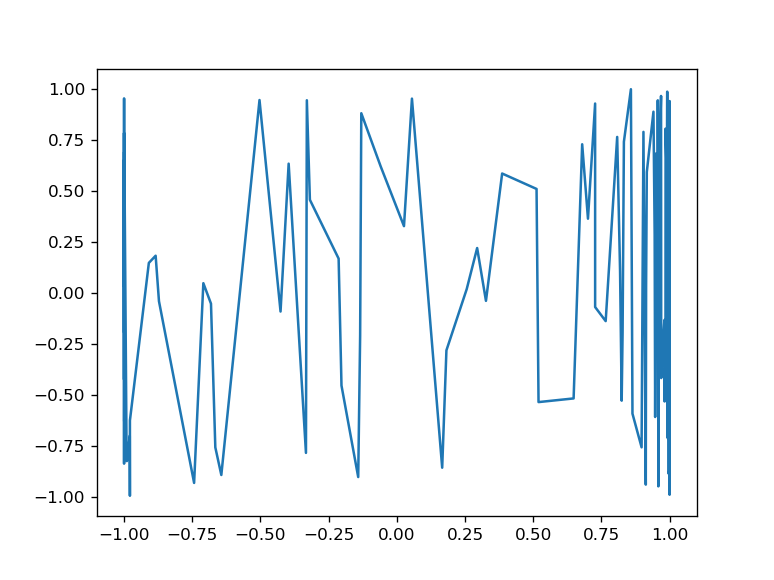

In [21]:
%matplotlib notebook
plt.plot(img[:,0],img[:,1])
plt.show()